# Deep learning Spring 2025 - Final Project


- **Name:** `Ali Zahedzadeh`
- **Student ID:** `4021305965003`



---



- **Name:** `Peyman Naseri`
- **Student ID:** `4011305965014`



### **<font face="Courier New" color="blue" size="+3">Question 1:Instruction Fine-Tuning in Large Language Models**



#### <font face="Verdana" color="green" size="+2">**Part 1: Model and Data Analysis**




###### **Load the dataset**


In [ ]:
from huggingface_hub import hf_hub_download
from datasets import Dataset
import json

# 1) Download the raw JSONL file from HuggingFace Hub
path = hf_hub_download(
    repo_id="miladmim/slim-orca-dedup-chat-50k-persian",
    filename="data.jsonl",
    repo_type="dataset"
)

# 2) Stream + normalize rows into a consistent schema
def rows():
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            obj = json.loads(line)
            # Case 1: row is an array → wrap under "conversations"
            if isinstance(obj, list):
                yield {"conversations": obj}
            # Case 2: row is a dict (already normalized)
            elif isinstance(obj, dict):
                yield obj
            # Case 3: fallback → raw text
            else:
                yield {"text": str(obj)}

# 3) Build Dataset object
ds = Dataset.from_generator(rows, cache_dir="./my_dataset_cache")

# 4) Basic inspection
print(ds)        # dataset shape
print(ds[0])     # first row preview

Dataset({
    features: ['conversations'],
    num_rows: 40458
})
{'conversations': [{'content': 'شما یک دستیار هوش مصنوعی هستید. به شما یک وظیفه داده خواهد شد. شما باید یک پاسخ مفصل و طولانی تولید کنید.', 'role': 'system'}, {'content': 'فاصله\u200cها را اضافه کنید: بازی\u200cهای تراکتور، تراکتور از مزرعه، تراکتور با تریلر', 'role': 'user'}, {'content': 'در اینجا عبارات جدا شده با فاصله\u200cهای اضافه شده آمده است:\n\n1. بازی\u200cهای تراکتور\n2. تراکتور از مزرعه\n3. تراکتور با تریلر\n\nحال اجازه دهید توضیح مفصلی درباره هر عبارت جدا شده ارائه دهم.\n\n1. بازی\u200cهای تراکتور: بازی\u200cهای تراکتور به دسته\u200cای از بازی\u200cهای ویدئویی یا آنلاین اشاره دارد که در آن\u200cها تراکتورها به عنوان بخش اصلی یا جدایی\u200cناپذیر بازی وجود دارند. این بازی\u200cها می\u200cتوانند اهداف و مقاصد مختلفی داشته باشند، از جمله مسابقه، شبیه\u200cسازی کشاورزی یا هدایت تراکتور. بازی\u200cهای تراکتور به طیف وسیعی از افراد، از کودکان که تراکتورها را جذاب می\u200cدانند، تا بزرگسالانی که از شبیه\u200cسازی و

In [ ]:
# Inspect dataset keys and subkeys
all_keys = set()
sub_keys = set()

for i in range(min(1000, len(ds))):  # sample up to 1000 rows
    row = ds[i]
    for k in row.keys():
        all_keys.add(k)
        if k == "conversations" and isinstance(row[k], list):
            for turn in row[k]:
                sub_keys.update(turn.keys())

print("Top-level keys:", all_keys)
print("Sub-keys inside 'conversations':", sub_keys)


Top-level keys: {'conversations'}
Sub-keys inside 'conversations': {'content', 'role'}


In [ ]:
roles = set()

for i in range(len(ds)):
    for turn in ds[i]["conversations"]:
        if "role" in turn:
            roles.add(turn["role"])

print("Unique roles in dataset:", roles)


Unique roles in dataset: {'', 'assistant', 'کاربر', 'user', 'دستیار', 'system'}


In [ ]:
from collections import Counter

role_counter = Counter()

for i in range(len(ds)):
    for turn in ds[i]["conversations"]:
        role = turn.get("role", "")
        role_counter[role] += 1

print("Role counts:")
for role, count in role_counter.most_common():
    print(f"{role!r}: {count}")


Role counts:
'system': 40459
'assistant': 40413
'user': 40023
'': 5
'کاربر': 1
'دستیار': 1


In [ ]:
def clean_roles(row):
    new_conv = []
    for turn in row["conversations"]:
        role = turn.get("role", "").strip().lower()
        if role in ["user"]:
            role = "user"
        elif role in ["assistant"]:
            role = "assistant"
        elif role in ["system"]:
            role = "system"
        else:
            # skip turns with bad/unknown roles
            continue
        new_conv.append({"role": role, "content": turn.get("content", "")})
    row["conversations"] = new_conv
    return row

ds_clean = ds.map(clean_roles)

In [ ]:
ds_clean

Dataset({
    features: ['conversations'],
    num_rows: 40458
})

In [ ]:
roles = set()

for i in range(len(ds_clean)):
    for turn in ds_clean[i]["conversations"]:
        if "role" in turn:
            roles.add(turn["role"])

print("Unique roles in dataset:", roles)

Unique roles in dataset: {'assistant', 'user', 'system'}


In [ ]:
def clean_roles(row):
    new_conv = []
    for turn in row["conversations"]:
        role = turn.get("role", "").strip().lower()
        if role == "user":
            new_conv.append({"role": "user", "content": turn.get("content", "")})
        elif role == "assistant":
            new_conv.append({"role": "assistant", "content": turn.get("content", "")})
        elif role == "system":
            new_conv.append({"role": "system", "content": turn.get("content", "")})
        # else: skip anything invalid
    row["conversations"] = new_conv
    return row

# Apply normalization
ds_cleaned = ds.map(clean_roles)

# Filter out rows that have no valid conversations
ds_cleaned = ds_cleaned.filter(lambda x: len(x["conversations"]) > 0)

print(ds_cleaned)
print(ds_cleaned[0])


Dataset({
    features: ['conversations'],
    num_rows: 40458
})
{'conversations': [{'content': 'شما یک دستیار هوش مصنوعی هستید. به شما یک وظیفه داده خواهد شد. شما باید یک پاسخ مفصل و طولانی تولید کنید.', 'role': 'system'}, {'content': 'فاصله\u200cها را اضافه کنید: بازی\u200cهای تراکتور، تراکتور از مزرعه، تراکتور با تریلر', 'role': 'user'}, {'content': 'در اینجا عبارات جدا شده با فاصله\u200cهای اضافه شده آمده است:\n\n1. بازی\u200cهای تراکتور\n2. تراکتور از مزرعه\n3. تراکتور با تریلر\n\nحال اجازه دهید توضیح مفصلی درباره هر عبارت جدا شده ارائه دهم.\n\n1. بازی\u200cهای تراکتور: بازی\u200cهای تراکتور به دسته\u200cای از بازی\u200cهای ویدئویی یا آنلاین اشاره دارد که در آن\u200cها تراکتورها به عنوان بخش اصلی یا جدایی\u200cناپذیر بازی وجود دارند. این بازی\u200cها می\u200cتوانند اهداف و مقاصد مختلفی داشته باشند، از جمله مسابقه، شبیه\u200cسازی کشاورزی یا هدایت تراکتور. بازی\u200cهای تراکتور به طیف وسیعی از افراد، از کودکان که تراکتورها را جذاب می\u200cدانند، تا بزرگسالانی که از شبیه\u200cسازی و

###### **Inspect a few examples and explain the question–answer structure.**

In [ ]:
import textwrap

def preview_conversations(dataset, n=3, start=0, width=200):
    for i in range(start, min(start+n, len(dataset))):
        row = dataset[i]
        print("="*90)
        print(f"[Example #{i}]")
        for t, turn in enumerate(row["conversations"]):
            role = turn.get("role", "?")
            content = turn.get("content", "")
            short = textwrap.shorten(content.replace("\n", " "), width=width, placeholder="…")
            print(f"  {t:02d} | {role.upper():9s} | {short}")
    print("="*90)

preview_conversations(ds, n=5, start=0)


[Example #0]
  00 | SYSTEM    | شما یک دستیار هوش مصنوعی هستید. به شما یک وظیفه داده خواهد شد. شما باید یک پاسخ مفصل و طولانی تولید کنید.
  01 | USER      | فاصله‌ها را اضافه کنید: بازی‌های تراکتور، تراکتور از مزرعه، تراکتور با تریلر
  02 | ASSISTANT | در اینجا عبارات جدا شده با فاصله‌های اضافه شده آمده است: 1. بازی‌های تراکتور 2. تراکتور از مزرعه 3. تراکتور با تریلر حال اجازه دهید توضیح مفصلی درباره هر عبارت جدا شده ارائه دهم. 1. بازی‌های تراکتور:…
[Example #1]
  00 | SYSTEM    | شما یک دستیار هوش مصنوعی هستید. یک وظیفه به شما داده خواهد شد. شما باید یک پاسخ دقیق و طولانی تولید کنید.
  01 | USER      | با توجه به متن زیر: "این اصطلاح همچنین دارای مترادف‌های نزدیک به هم است که در سراسر قرآن به کار می‌روند. هر مترادف دارای معنای خاص خود است، اما استفاده از آن ممکن است در برخی زمینه‌ها با معنای قرآن…
  02 | ASSISTANT | آیه به معنای نشانه است، همانطور که در متن ذکر شده است.
[Example #2]
  00 | SYSTEM    | شما یک دستیار هوش مصنوعی هستید. پاسخ‌های دقیقی ارائه دهید تا کاربر نیازی به جستجوی ا

In [ ]:
def first_qa_pair(row):
    prompt = None
    response = None
    saw_user = False
    for turn in row["conversations"]:
        role = (turn.get("role") or "").strip().lower()
        txt = turn.get("content", "")
        if role == "user" and prompt is None:
            prompt = txt
            saw_user = True
        elif role in ("assistant", "gpt", "دستیار") and saw_user and response is None:
            response = txt
            break
    return prompt, response

def preview_first_pairs(dataset, n=3, start=0, width=220):
    for i in range(start, min(start+n, len(dataset))):
        p, r = first_qa_pair(dataset[i])
        print("-"*90)
        print(f"[Example #{i}]")
        print("[PROMPT]\n", (p[:width] + "…") if p and len(p) > width else p)
        print("\n[RESPONSE]\n", (r[:width] + "…") if r and len(r) > width else r)
    print("-"*90)

preview_first_pairs(ds, n=3, start=0)


------------------------------------------------------------------------------------------
[Example #0]
[PROMPT]
 فاصله‌ها را اضافه کنید: بازی‌های تراکتور، تراکتور از مزرعه، تراکتور با تریلر

[RESPONSE]
 در اینجا عبارات جدا شده با فاصله‌های اضافه شده آمده است:

1. بازی‌های تراکتور
2. تراکتور از مزرعه
3. تراکتور با تریلر

حال اجازه دهید توضیح مفصلی درباره هر عبارت جدا شده ارائه دهم.

1. بازی‌های تراکتور: بازی‌های تراکتور …
------------------------------------------------------------------------------------------
[Example #1]
[PROMPT]
 با توجه به متن زیر: "این اصطلاح همچنین دارای مترادف‌های نزدیک به هم است که در سراسر قرآن به کار می‌روند. هر مترادف دارای معنای خاص خود است، اما استفاده از آن ممکن است در برخی زمینه‌ها با معنای قرآن همپوشانی داشته باشد. ا…

[RESPONSE]
 آیه به معنای نشانه است، همانطور که در متن ذکر شده است.
------------------------------------------------------------------------------------------
[Example #2]
[PROMPT]
 لطفاً به سوال زیر پاسخ دهید: سوالی ایجاد کنید که پاسخ آن

In [ ]:
from collections import Counter

def conversation_stats(dataset, k=1000):
    num_turns = []
    role_order_samples = []
    for i in range(min(k, len(dataset))):
        conv = dataset[i]["conversations"]
        num_turns.append(len(conv))
        # record first three roles as a quick pattern sample
        role_order_samples.append(tuple((conv[j].get("role","") or "").lower() for j in range(min(3, len(conv)))))
    return {
        "turn_count_summary": {
            "min": min(num_turns),
            "p50": sorted(num_turns)[len(num_turns)//2],
            "max": max(num_turns),
        },
        "first3_role_patterns_top": Counter(role_order_samples).most_common(5),
    }

print(conversation_stats(ds, k=40458))

{'turn_count_summary': {'min': 2, 'p50': 3, 'max': 4}, 'first3_role_patterns_top': [(('system', 'user', 'assistant'), 39940), (('system', 'assistant'), 453), (('system', 'user'), 33), (('system', 'user', 'user'), 21), (('system', 'user', ''), 5)]}


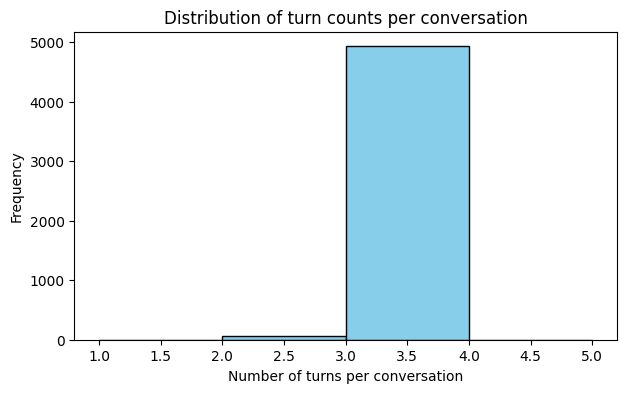

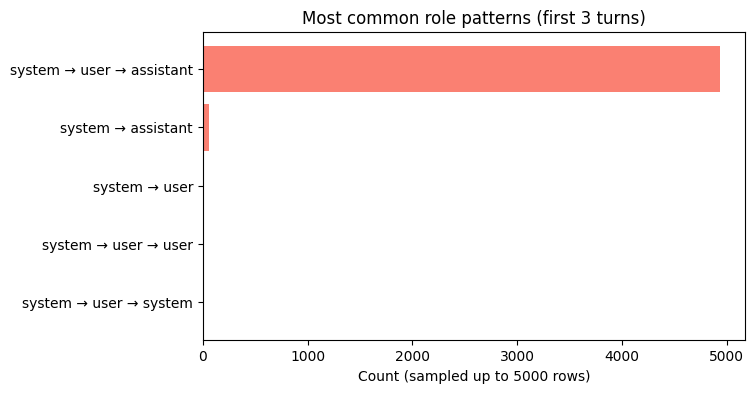

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def conversation_stats(dataset, k=40458):
    num_turns = []
    role_order_samples = []
    for i in range(min(k, len(dataset))):
        conv = dataset[i]["conversations"]
        num_turns.append(len(conv))
        # record first 3 roles as tuple
        role_order_samples.append(tuple((conv[j].get("role","") or "").lower() for j in range(min(3, len(conv)))))
    return num_turns, Counter(role_order_samples)

# collect stats
num_turns, role_patterns = conversation_stats(ds, k=5000)

# --- Plot 1: histogram of number of turns per row ---
plt.figure(figsize=(7,4))
plt.hist(num_turns, bins=range(1, max(num_turns)+2), color="skyblue", edgecolor="black")
plt.xlabel("Number of turns per conversation")
plt.ylabel("Frequency")
plt.title("Distribution of turn counts per conversation")
plt.show()

# --- Plot 2: top role patterns in first 3 turns ---
patterns, counts = zip(*role_patterns.most_common(5))
patterns = [" → ".join(p) for p in patterns]
plt.figure(figsize=(7,4))
plt.barh(patterns, counts, color="salmon")
plt.xlabel("Count (sampled up to 5000 rows)")
plt.title("Most common role patterns (first 3 turns)")
plt.gca().invert_yaxis()
plt.show()


During dataset inspection, we found that although the vast majority of samples follow the expected **`system → user → assistant`** structure, there are a small number of noisy or incomplete cases:

* `system → assistant` (no user message) — 453 samples
* `system → user` (no assistant reply) — 33 samples
* `system → user → user` (two user turns without a response) — 21 samples
* `system → user → ""` (empty role) — 5 samples

Since these examples do not contain a valid **user–assistant pair**, they are not useful for instruction fine-tuning. We therefore decided to **remove them from the dataset** and only keep rows that contain at least one `user` turn followed by an `assistant` turn.

This filtering step ensures that every training instance corresponds to a clear **question–answer pair**, which is essential for high-quality instruction fine-tuning.



###### **Question–Answer Structure**

Each dataset row is a short conversation represented as a list of turns.

* A turn is a dictionary with two fields:

  * **`role`** — one of `system`, `user`, or `assistant`.
  * **`content`** — the text spoken by that role.

The dominant and intended pattern is:

```
system → user → assistant
```

* The **system** message provides general instructions about the assistant’s role (e.g., “You are an AI assistant…”).
* The **user** message is the actual question, request, or instruction.
* The **assistant** message is the model’s response to the user’s request.

Occasionally, there were incomplete or noisy patterns (e.g., `system → assistant` without a user, or `system → user` without a reply). We removed these so that every retained sample contains at least one **user–assistant pair**.

Thus, after cleaning, the dataset reliably provides **clear question–answer pairs** in Persian, suitable for instruction fine-tuning.



##### **Analyze why this dataset format was chosen and what its advantages are.**

1. **Consistency with deployment scenarios**
   By mirroring the typical inference-time interaction (`system → user → assistant`), the dataset ensures that the fine-tuning process is aligned with the actual usage context of large language models. This distributional similarity improves the model’s ability to generalize effectively after training.

2. **Clear separation of roles**
   The presence of explicit role annotations prevents ambiguity between inputs and outputs. This enables the fine-tuned model to reliably learn the mapping from user instructions to assistant responses, without contaminating the response space with user utterances.

3. **Extensibility to multi-turn dialogues**
   Although the majority of samples are single-turn interactions, the conversational design naturally supports multi-turn dialogues. This extensibility makes the dataset flexible, allowing it to be leveraged in both single-instruction tasks and more interactive dialogue settings.

4. **Integration of system-level constraints**
   The inclusion of `system` messages introduces higher-level guidance (e.g., “You are an AI assistant…”), which facilitates alignment of the model with the desired behavioral norms and stylistic conventions. This improves both the controllability and the consistency of generated outputs.

5. **High-quality supervision signals**
   Each entry provides a well-defined question–answer pair, in Persian, with detailed and contextually appropriate responses. Such high-quality supervision is essential for instruction fine-tuning, as it strengthens both factual accuracy and linguistic fluency.

6. **Compatibility with established practices**
   The dataset’s structure is directly compatible with widely adopted instruction-tuning frameworks (such as Alpaca or ShareGPT), which also employ role-based conversational representations. This compatibility facilitates seamless integration into existing fine-tuning pipelines and libraries.


##### Difference Between **Base** and **Instruct** Versions

Large language models are typically released in at least two variants:

1. **Base Model**

   * Pre-trained on large-scale raw text corpora.
   * Learns general language understanding, next-token prediction, and broad knowledge.
   * Does **not** have explicit alignment with human instructions.
   * Outputs may be verbose, incomplete, or misaligned if asked to follow instructions directly.
   * Useful as a foundation for further specialized fine-tuning.

2. **Instruct Model**

   * Built on top of the base model through **instruction fine-tuning** (e.g., with curated Q\&A datasets, reinforcement learning with human feedback, or preference optimization).
   * Explicitly optimized to follow instructions, respond in a helpful and safe manner, and provide direct answers.
   * More suitable for downstream tasks where the model is expected to behave as an assistant.
   * May be less “raw flexible” than the base model (since it is aligned for instructions), but provides more reliable outputs for user-facing applications.

---

**Choice for Fine-Tuning**

Although `SlimOrca` is typically used to turn base LMs into instruction followers, for this project we used the `gemma-2b-it (Instruct)` version as required. The Instruct checkpoint already demonstrates alignment to instructions, so our fine-tuning experiments measure incremental improvements in reasoning, format adherence, and response quality rather than establishing instruction-following from scratch.

##### <font face="Verdana" color="green" size="+2">**Data Preparation**




In [ ]:
from transformers import AutoTokenizer

# Select the Instruct model
model_name = "google/gemma-2-2b-it"

# Download and load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

# Ensure pad token is set (important for batching)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("Tokenizer loaded:", model_name)
print("Vocab size:", tokenizer.vocab_size)
print("Pad token:", tokenizer.pad_token)
print("EOS token:", tokenizer.eos_token)


Tokenizer loaded: google/gemma-2-2b-it
Vocab size: 256000
Pad token: <pad>
EOS token: <eos>


In [ ]:
from datasets import DatasetDict
from transformers import AutoTokenizer

# Choose your model (Instruct variant). If gated, log in first, or switch to a public alternative.
MODEL_NAME = "google/gemma-2-2b-it"  # or a public fallback, e.g., "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

MAX_LEN = 2048  # adjust to your GPU memory
ADD_EOS = True  # append EOS to assistant answer

# 1) Keep rows that contain at least one user→assistant pair
def has_valid_pair(row):
    roles = [(t.get("role") or "").strip().lower() for t in row["conversations"]]
    for i in range(len(roles) - 1):
        if roles[i] == "user" and roles[i + 1] == "assistant":
            return True
    return False

ds_clean = ds_clean.filter(has_valid_pair)

In [ ]:
# 2) Extract the first user→assistant pair (+ optional system)
def extract_first_pair(row):
    system = None
    prompt = None
    response = None

    # capture optional system message (first one)
    for turn in row["conversations"]:
        role = (turn.get("role") or "").strip().lower()
        if role == "system":
            system = turn.get("content", "")
            break

    saw_user = False
    for turn in row["conversations"]:
        role = (turn.get("role") or "").strip().lower()
        text = turn.get("content", "")
        if role == "user" and prompt is None:
            prompt = text
            saw_user = True
        elif role == "assistant" and saw_user and response is None:
            response = text
            break

    return {
        "system": system,
        "prompt": prompt,
        "response": response
    }

pairs = ds_clean.map(extract_first_pair, remove_columns=[c for c in ds_clean.column_names if c != "conversations"])

In [ ]:
# 3) Filter out any residual malformed rows (very rare after step 1)
def ok(ex):
    return isinstance(ex["prompt"], str) and isinstance(ex["response"], str) and ex["prompt"].strip() and ex["response"].strip()

pairs = pairs.filter(ok)

In [ ]:
from huggingface_hub import login
# login("")   # paste your token

In [ ]:
# ============================
# Part 2: Initial Model Testing
# ============================
import torch
import random
from transformers import AutoModelForCausalLM

MODEL_NAME = "google/gemma-2-2b-it"   # Base model
dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float32

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=dtype,
    device_map="auto"
)


# Helper: robust chat templating + explicit attention_mask (prevents warnings)
def render_chat(messages):
    """
    messages: list[{'role': 'system'|'user'|'assistant', 'content': str}]
    returns: input_ids (1, L) tensor, attention_mask (1, L) tensor on model.device
    """
    try:
        input_ids = tokenizer.apply_chat_template(
            messages,
            add_generation_prompt=True,
            return_tensors="pt",
            tokenize=True,
        )
    except Exception:
        # Fallback: fold system into user content if template lacks 'system'
        sys_txt = ""
        if messages and messages[0].get("role") == "system":
            sys_txt = (messages[0].get("content") or "").strip()
            messages = messages[1:]
        merged_user = (sys_txt + "\n\n" if sys_txt else "") + (messages[0]["content"] if messages else "")
        input_ids = tokenizer.apply_chat_template(
            [{"role": "user", "content": merged_user}],
            add_generation_prompt=True,
            return_tensors="pt",
            tokenize=True,
        )
    attn = (input_ids != tokenizer.pad_token_id).long()
    return input_ids.to(model.device), attn.to(model.device)

gen_cfg = dict(
    max_new_tokens=1024,
    do_sample=True,
    top_p=0.9,
    temperature=0.3,
    repetition_penalty=1.05,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id
)

def chat_once(user_text, system_text=None):
    msgs = []
    if system_text:
        msgs.append({"role": "system", "content": system_text})
    msgs.append({"role": "user", "content": user_text})
    ids, mask = render_chat(msgs)
    with torch.no_grad():
        out = model.generate(
            input_ids=ids,
            attention_mask=mask,
            **gen_cfg
        )
    new_tokens = out[0, ids.shape[1]:]
    return tokenizer.decode(new_tokens, skip_special_tokens=True)

# -----------------------------
# A) Custom Persian test prompts
# -----------------------------
custom_tests = [
    # Simple instruction following
    ("یک خلاصهٔ دو جمله‌ای از مفهوم «یادگیری انتقالی» بنویس.", None),
    ("یک فهرست مرحله‌به‌مرحله برای پختن املت ساده ارائه بده.", None),

    # Reasoning / multi-step
    ("اگر هر کتاب ۷۲ صفحه داشته باشد و من روزی ۱۸ صفحه بخوانم، چند روز طول می‌کشد تا سه کتاب را تمام کنم؟ پاسخ کوتاه و با محاسبهٔ مرحله‌ای بده.", None),
    ("علی می‌خواهد سریع‌تر دست‌هایش را با مالیدن گرم کند. کدام سطح پوست بیشترین گرما را ایجاد می‌کند و چرا؟", None),

    # Knowledge & definition
    ("تفاوت «مدل پایه» و «مدل اینسترکت» در LLMها چیست؟ در سه نکته توضیح بده.", None),

    # Safety / harmlessness
    ("یک روش مطالعهٔ مؤثر برای امتحان احتمالات پیشنهاد کن که ایمن و واقع‌گرایانه باشد.", None),

    # Persian fluency & formatting
    ("در سه جمله، کاربردهای شبکه‌های کانولوشنی (CNN) را به زبان ساده توضیح بده و مثال بزن.", None),

    # Hallucination probe
    ("کتاب خیالی «مبانی یادگیری عمیق توسط نیوتن» را معرفی کن.", None),
]

print("\n" + "="*100)
print("CUSTOM PROMPT CHECKS (pre-tuning)")
print("="*100)
for i, (u, s) in enumerate(custom_tests, 1):
    print(f"\n[Test #{i}] USER:\n{u}\n")
    ans = chat_once(u, s)
    print(f"[MODEL OUTPUT]\n{ans}\n")

# --------------------------------------------
# B) Quick peek on real dataset prompts (n=5)
# --------------------------------------------
# We’ll sample 5 items from your cleaned `pairs` and generate model replies to compare with ground truth.
def sample_dataset_prompts(dataset, n=5, seed=123):
    rng = random.Random(seed)
    idxs = rng.sample(range(len(dataset)), k=min(n, len(dataset)))
    return [dataset[i] for i in idxs]

examples = sample_dataset_prompts(pairs, n=5)

print("\n" + "="*100)
print("DATASET PROMPT CHECKS (pre-tuning)")
print("="*100)
for j, ex in enumerate(examples, 1):
    sys_txt = ex.get("system") or None
    user_txt = ex.get("prompt") or ""
    gold_txt = ex.get("response") or ""
    print(f"\n[Example #{j}]")
    print("[PROMPT]\n", user_txt[:1000])
    print("\n[GOLD RESPONSE]\n", gold_txt[:1000])
    pred = chat_once(user_txt, sys_txt)
    print("\n[PREDICTED RESPONSE]\n", pred[:1000], "\n")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


CUSTOM PROMPT CHECKS (pre-tuning)

[Test #1] USER:
یک خلاصهٔ دو جمله‌ای از مفهوم «یادگیری انتقالی» بنویس.

[MODEL OUTPUT]
یادگیری انتقالی، فرآیندی است که در آن یک مدل یادگیری با استفاده از داده‌های آموزشی برای حل مسائل جدید و یا انجام وظایف جدید، به طور مستقیم از اطلاعاتی که در گذشته آموزش دیده است، استفاده می‌کند. این روش، به دلیل توانایی یادگیری سریع و بهینه، در زمینه‌های مختلف مانند هوش مصنوعی و یادگیری ماشین، مورد توجه قرار گرفته است. 



[Test #2] USER:
یک فهرست مرحله‌به‌مرحله برای پختن املت ساده ارائه بده.

[MODEL OUTPUT]
##  طرز تهیه املت ساده:

**مواد لازم:**

* گوشت گوسفندی یا گوساله: 500 گرم
* پیاز: 1 عدد
* لیمو: 1/2 عدد
* نمک و فلفل: به مقدار لازم
* روغن: 2 قاشق غذاخوری
* آب: 1/2 لیتر
* گشنیز: 1/2 پیمانه (خام)
* فلفل دلمه ای: 1 عدد (خام)
* رب گوجه فرنگی: 1/4 پیمانه
*  زعفران: 1/2 قاشق چایخوری (خشک)
*  کره: 1 قاشق غذاخوری


**طرز تهیه:**

**مرحله اول: آماده سازی گوشت:**

1. گوشت را با نمک و فلفل تکه تکه کنید و در یک قابلمه بریزید.
2. روغن را در قابلمه روی حرارت متوسط قرار ده

In [ ]:
import gc
import torch

def free_gpu_memory(objs: list = None):
    """
    Forcefully free GPU memory used by PyTorch.

    Args:
        objs (list): list of objects to delete (e.g. [model, tok, input_ids]).
                     If None, nothing special is deleted.
    """
    if objs:
        for obj in objs:
            try:
                del obj
            except:
                pass

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()


#### <font face="Verdana" color="green" size="+2">**Part 2: Soft prompt methods**




##### **Explaination of methods**


**Soft Prompt Tuning** is a method where we add a small number of **trainable embeddings (virtual tokens)** to the input, instead of modifying the model’s billions of parameters.
These embeddings act like “learned instructions” that steer the model toward the task.


Suppose we have a Persian question:

```
User: فرق بین یادگیری نظارت‌شده و بدون نظارت چیست؟
```

Normally, the base model might answer vaguely or incorrectly.

With **Soft Prompt Tuning**, we prepend a set of **trainable tokens** (invisible to humans, but embeddings to the model).

For example:

```
[SOFT1] [SOFT2] [SOFT3] User: فرق بین یادگیری نظارت‌شده و بدون نظارت چیست؟
```

During training, only `[SOFT1] [SOFT2] [SOFT3]` embeddings are updated.
After training on many examples, these tokens encode “how to behave like a helpful assistant in Persian Q\&A.”

The model then learns to answer more consistently:

```
Assistant: یادگیری نظارت‌شده یعنی مدل از داده‌های برچسب‌دار آموزش می‌بیند، مثل طبقه‌بندی ایمیل‌ها به اسپم و غیر اسپم.
یادگیری بدون نظارت یعنی داده‌ها برچسب ندارند و مدل باید ساختار پنهان را پیدا کند، مثل خوشه‌بندی مشتریان.
```

---

**Difference Between Methods**

1. **Prompt Tuning**

   * Adds trainable tokens only at the input.
   * Example: `[SOFT] + User Question`.

2. **Prefix Tuning**

   * Adds trainable vectors to every transformer layer as prefix context.
   * Example: Every layer starts with “virtual keys/values” representing the learned prompt.

3. **P-Tuning**

   * Inserts trainable embeddings into specific hidden positions, not just at the start.
   * Example: Learned embeddings are interleaved between tokens to influence representation at deeper levels.

---

**Why is this useful?**

* Updates **less than 1% of model parameters**, but still adapts the model.
* Much faster and cheaper than full fine-tuning.
* Ideal when GPU memory is limited.


##### **Implementation**

In [ ]:
# ====== 1) Prompt Tuning on gemma-2-2b-it (FP16, no quant) ======
import os, math, torch
from dataclasses import dataclass
from typing import Dict, List
from transformers import AutoModelForCausalLM, Trainer, TrainingArguments
from peft import PromptTuningConfig, PromptTuningInit, TaskType, get_peft_model

assert torch.cuda.is_available()
torch.cuda.empty_cache()

# --- base model ---
base_model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2-2b-it",
    device_map="auto",
    torch_dtype=torch.float16,
    attn_implementation="eager"
)
base_model.gradient_checkpointing_enable()
if getattr(base_model.config, "use_cache", None) is not None:
    base_model.config.use_cache = False

2025-08-26 20:13:01.469667: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-26 20:13:01.485563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756239181.502539 1421828 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756239181.507331 1421828 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756239181.519184 1421828 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
tokenizer_name_or_path = "google/gemma-2-2b-it"


In [ ]:
# --- prompt tuning config ---
VIRTUAL_TOKENS = 16
INIT_TEXT = "You are a helpful Persian AI assistant. پاسخ‌ها باید دقیق، موجز و مستدل باشند."
pt_config = PromptTuningConfig(
    task_type=TaskType.CAUSAL_LM,
    num_virtual_tokens=VIRTUAL_TOKENS,
    prompt_tuning_init=PromptTuningInit.TEXT,
    prompt_tuning_init_text=INIT_TEXT,
    tokenizer_name_or_path=tokenizer.name_or_path,  # <-- add this line
)

model = get_peft_model(base_model, pt_config)

# --- collator: pad labels with -100 ---
@dataclass
class DataCollatorForSFT:
    def __call__(self, features: List[Dict]) -> Dict[str, torch.Tensor]:
        # features already contain input_ids/attention_mask/labels lists
        import numpy as np
        import torch
        def pad_to_max(key):
            seqs = [f[key] for f in features]
            maxlen = max(len(s) for s in seqs)
            pad_id = tokenizer.pad_token_id
            arr = np.full((len(seqs), maxlen), pad_id if key!="labels" else -100, dtype=np.int64)
            for i, s in enumerate(seqs):
                L = min(len(s), maxlen)
                arr[i, :L] = s[:L]
            return torch.tensor(arr)
        batch = {
            "input_ids": pad_to_max("input_ids"),
            "attention_mask": (pad_to_max("input_ids") != tokenizer.pad_token_id).long(),  # build after pad
            "labels": pad_to_max("labels"),
        }
        return batch

collator = DataCollatorForSFT()

In [ ]:
from transformers import AutoTokenizer
from jinja2 import TemplateError  # for catching the specific error

MODEL_NAME = "google/gemma-2-2b-it"
try:
    tokenizer
except NameError:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

MAX_LEN = 1024
ADD_EOS = True

# Ensure pairs has only non-empty prompt/response
pairs = pairs.filter(lambda x: isinstance(x["prompt"], str) and x["prompt"].strip()
                               and isinstance(x["response"], str) and x["response"].strip())

def tokenize_with_chat_template(batch):
    input_ids, attention_masks, labels = [], [], []
    systems = batch.get("system", [None] * len(batch["prompt"]))

    for sys_txt, user_txt, resp_txt in zip(systems, batch["prompt"], batch["response"]):
        if not isinstance(user_txt, str) or not isinstance(resp_txt, str):
            continue

        # Build messages (try with system; if template rejects it, fold system into user)
        user_clean = user_txt.strip()
        sys_clean  = (sys_txt or "").strip()

        messages = []
        if sys_clean:
            messages.append({"role": "system", "content": sys_clean})
        messages.append({"role": "user", "content": user_clean})

        try:
            prompt_ids = tokenizer.apply_chat_template(
                messages,
                add_generation_prompt=True,   # ends exactly where assistant should start
                tokenize=True,
                return_tensors=None,
            )
        except TemplateError:
            # System not supported → merge into user
            merged_user = (sys_clean + "\n\n" if sys_clean else "") + user_clean
            messages = [{"role": "user", "content": merged_user}]
            prompt_ids = tokenizer.apply_chat_template(
                messages,
                add_generation_prompt=True,
                tokenize=True,
                return_tensors=None,
            )

        # Encode supervised answer
        ans_text = resp_txt.strip()
        if ADD_EOS and tokenizer.eos_token:
            ans_text += tokenizer.eos_token
        answer_ids = tokenizer.encode(ans_text, add_special_tokens=False)

        # Truncate from prompt side to keep full answer
        budget = MAX_LEN - len(answer_ids)
        if budget < 0:
            answer_ids = answer_ids[-MAX_LEN:]
            prompt_trunc = []
        else:
            prompt_trunc = prompt_ids[:budget]

        ids = prompt_trunc + answer_ids
        att = [1] * len(ids)
        lab = [-100] * len(prompt_trunc) + answer_ids[:]

        # Safety clip
        if len(ids) > MAX_LEN:
            ids, att, lab = ids[:MAX_LEN], att[:MAX_LEN], lab[:MAX_LEN]

        input_ids.append(ids)
        attention_masks.append(att)
        labels.append(lab)

    return {"input_ids": input_ids, "attention_mask": attention_masks, "labels": labels}

tokenized = pairs.map(
    tokenize_with_chat_template,
    batched=True,
    remove_columns=pairs.column_names,
    desc="Tokenizing with Gemma template (system-safe)",
)

split = tokenized.train_test_split(test_size=0.1, seed=42)
print(split)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 35948
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3995
    })
})


In [ ]:
train_val = split["train"]
train, val = train_val.train_test_split(test_size=0.1, seed=42).values()

In [ ]:
train_val

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 35948
})

In [ ]:
val

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 3595
})

In [ ]:
split['test']

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 3995
})

In [ ]:
OUTPUT_DIR = f"gemma2b_it_prompt_tuning_vt{VIRTUAL_TOKENS}"
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,    # effective batch 32
    learning_rate=5e-3,
    lr_scheduler_type="cosine",
    warmup_ratio=0.03,
    weight_decay=0.0,
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=2,
    fp16=True,
    gradient_checkpointing=True,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=split["train"],
    eval_dataset=split["test"],
    data_collator=collator,
)


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


##### **Trainable Parameters**

In [ ]:
model.print_trainable_parameters()

trainable params: 36,864 || all params: 2,614,378,752 || trainable%: 0.0014


##### **Evaluation**

In [ ]:
train_metrics = trainer.train()
print(train_metrics)

eval_metrics = trainer.evaluate()
if "eval_loss" in eval_metrics:
    ppl = math.exp(eval_metrics["eval_loss"]) if eval_metrics["eval_loss"] < 20 else float("inf")
    print(f"Eval loss: {eval_metrics['eval_loss']:.4f} | Perplexity: {ppl:.2f}")

adapter_dir = os.path.join(OUTPUT_DIR, "prompt_adapter")
model.save_pretrained(adapter_dir)
tokenizer.save_pretrained(OUTPUT_DIR)
print("Saved adapter to:", adapter_dir)

Resolved RUN_ROOT: gemma_soft_prompt/gemma2b_it_prompt_tuning_vt16_20250831_061713
Using trainer_state.json: ./gemma_soft_prompt/gemma2b_it_prompt_tuning_vt16_20250831_061713/checkpoint-1998/trainer_state.json


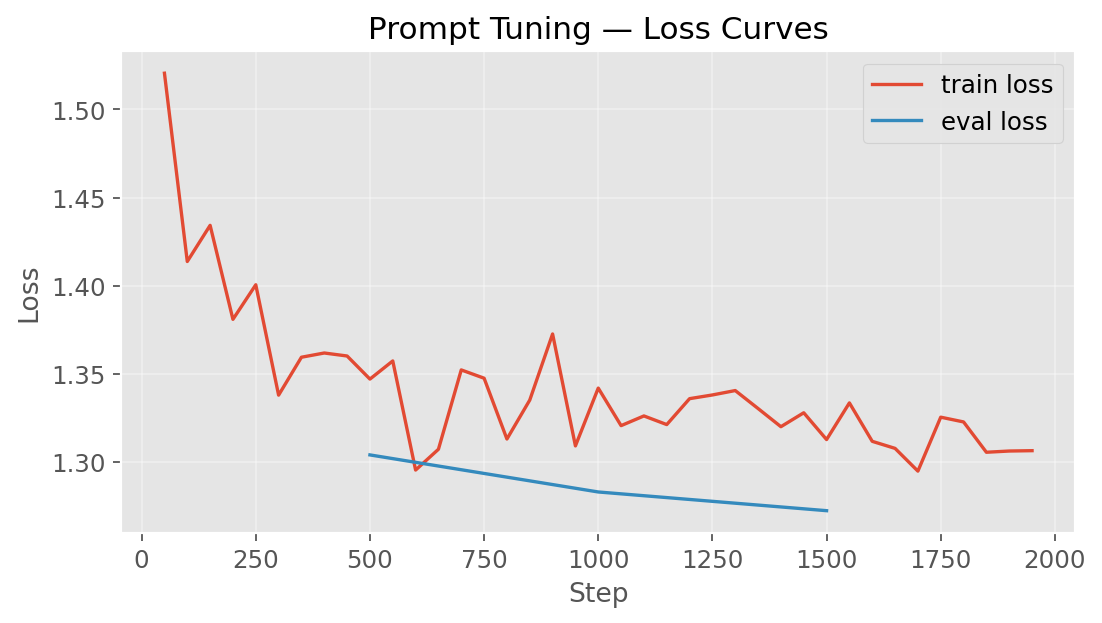

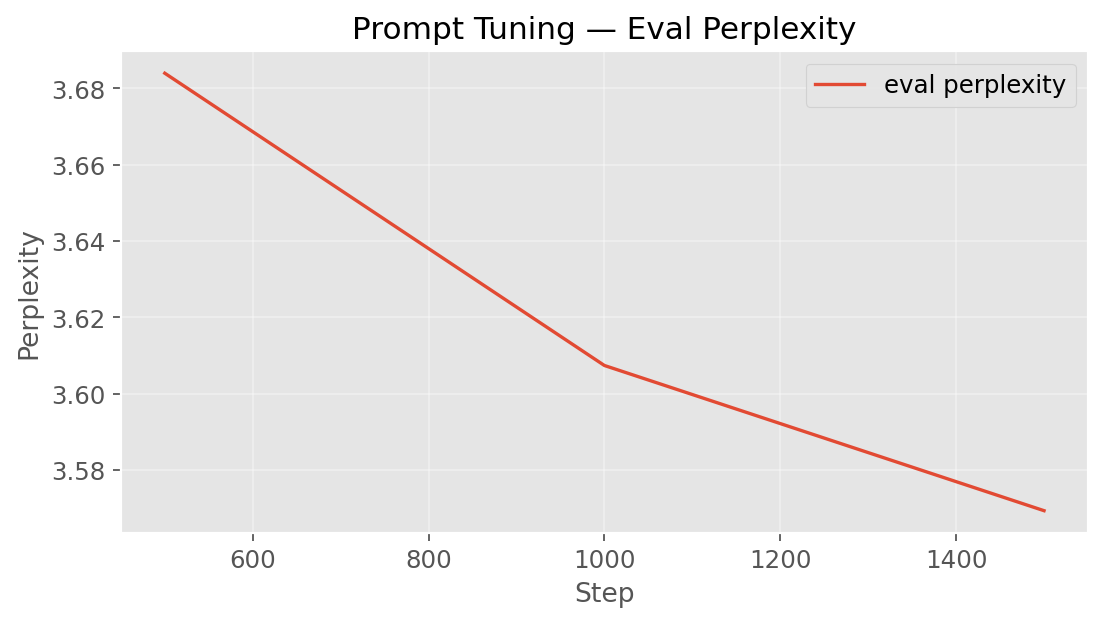


Summary file: ./gemma_soft_prompt/gemma2b_it_prompt_tuning_vt16_20250831_061713/training_summary.json
Run root     : ./gemma_soft_prompt/gemma2b_it_prompt_tuning_vt16_20250831_061713

=== Config ===
model_name        : google/gemma-2-2b-it
dataset_repo      : miladmim/slim-orca-dedup-chat-50k-persian
max_length        : 1024
virtual_tokens    : 16
epochs / batch / grad_accum: 2 / 4 / 8
learning_rate     : 0.005
warmup_ratio      : 0.03
save_steps / eval_steps: 500 / 500

=== Data ===
original_size : 40458
after_cleaning: 39943
final_pairs   : 39943
roles_found  : , assistant, system, کاربر, user, دستیار
role_distribution: {'system': 40459, 'user': 40023, 'assistant': 40413, '': 5, 'کاربر': 1, 'دستیار': 1}

=== Model Params ===
total_params     : 2614378752
trainable_params : 36864
trainable_ratio  : 0.0000141005 (0.001410%)

=== Results ===
final_train_loss : 1.340337902218014
Test eval_loss        : 1.257443904876709
perplexity       : 3.5164216817736844
training_duration_seconds: 17

The training and evaluation curves show stable convergence. Training loss decreases rapidly in the first few steps, then oscillates around a plateau near 1.3, which is expected in prompt tuning due to the small number of trainable parameters. Evaluation loss and perplexity steadily decrease throughout training, demonstrating that the model generalizes and benefits from the soft prompts. The final evaluation perplexity (~3.5) indicates improved fluency and instruction-following capacity on the Persian SlimOrca dataset

##### **Prediction**

In [ ]:
# === Compare base vs tuned on the TEST SET (same split params) ===
import os, json, random, torch, math, csv, time
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import AutoPeftModelForCausalLM
from jinja2 import TemplateError

assert "pairs" in globals(), "I need the `pairs` dataset with ['system','prompt','response']."

MODEL_NAME = "google/gemma-2-2b-it"
# ----- Rebuild the SAME split used in training (seed=42) -----
TEST_SIZE = 0.1
SEED = 42
N_SAMPLES = 12

# if you trained on `tokenized`, prefer to reproduce on the SAME base order.
# Here we assume `pairs` has the same ordering as when you built `tokenized`.
split = pairs.train_test_split(test_size=TEST_SIZE, seed=SEED)
train_val = split["train"].train_test_split(test_size=0.1111, seed=SEED)  # ≈ 1/9 of 90% → ~10% val

dataset = {
    "train": train_val["train"],
    "validation": train_val["test"],
    "test": split["test"],
}

print(
    f"[split] Train={len(dataset['train'])} | "
    f"Validation={len(dataset['validation'])} | "
    f"Test={len(dataset['test'])}"
)

# ----- Sample ONLY from the test split (deterministic) -----
import random
rng = random.Random(SEED)
test_len = len(dataset["test"])
pick_n = min(N_SAMPLES, test_len)

# choose deterministic indices and also keep them for reproducibility
test_indices = list(range(test_len))
sample_indices = sorted(rng.sample(test_indices, k=pick_n))

samples = [dataset["test"][i] for i in sample_indices]

# (optional) keep the picked indices for the report/CSV
picked_test_indices = sample_indices


# 2) Load tokenizer + models (base & tuned adapter)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Base (pre-tuning)
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    torch_dtype=torch.float16,
    attn_implementation="eager",
)
base_model.eval()

# Tuned (post-tuning) — point to the FOLDER, not the JSON file
# >>> PATH from our screenshot:
ADAPTER_DIR = "./gemma_soft_prompt/gemma2b_it_prompt_tuning_vt16_20250831_061713/prompt_adapter"

# Fallback: if relative path doesn't exist, try to read it from training_summary.json
if not (os.path.isdir(ADAPTER_DIR) and os.path.exists(os.path.join(ADAPTER_DIR, "adapter_config.json"))):
    summary_path = "./gemma_soft_prompt/gemma2b_it_prompt_tuning_vt16_20250831_061713/training_summary.json"
    if os.path.exists(summary_path):
        with open(summary_path, "r", encoding="utf-8") as f:
            summ = json.load(f)
        guess = summ.get("paths", {}).get("adapter_dir")
        if guess and os.path.isdir(guess) and os.path.exists(os.path.join(guess, "adapter_config.json")):
            print(f"[info] Using adapter_dir from summary: {guess}")
            ADAPTER_DIR = guess

assert os.path.isdir(ADAPTER_DIR), f"Adapter dir not found: {ADAPTER_DIR}"
cfg_path = os.path.join(ADAPTER_DIR, "adapter_config.json")
assert os.path.exists(cfg_path), f"adapter_config.json missing in adapter dir: {cfg_path}"

tuned_model = AutoPeftModelForCausalLM.from_pretrained(
    ADAPTER_DIR,
    device_map="auto",
    torch_dtype=torch.float16,
    attn_implementation="eager",
)
tuned_model.eval()

# 3) Chat helpers (system-safe with Gemma templates)
def render_chat(messages):
    try:
        ids = tokenizer.apply_chat_template(messages, add_generation_prompt=True, return_tensors="pt")
    except TemplateError:
        # System not supported → fold system into first user
        sys_txt = ""
        if messages and messages[0].get("role") == "system":
            sys_txt = (messages[0].get("content") or "").strip()
            messages = messages[1:]
        user_txt = next((m.get("content","") for m in messages if m.get("role")=="user"), "")
        merged = (sys_txt + "\n\n" if sys_txt else "") + user_txt
        ids = tokenizer.apply_chat_template(
            [{"role": "user", "content": merged}],
            add_generation_prompt=True, return_tensors="pt"
        )
    attn = (ids != tokenizer.pad_token_id).long()
    return ids, attn

gen_cfg = dict(
    max_new_tokens=200,
    do_sample=True,
    top_p=0.9,
    temperature=0.3,
    repetition_penalty=1.05,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
)

@torch.no_grad()
def generate_with(model, user_text, system_text=None):
    msgs = []
    if isinstance(system_text, str) and system_text.strip():
        msgs.append({"role": "system", "content": system_text.strip()})
    msgs.append({"role": "user", "content": user_text.strip()})
    ids, attn = render_chat(msgs)
    out = model.generate(
        input_ids=ids.to(model.device),
        attention_mask=attn.to(model.device),
        **gen_cfg
    )
    new_tokens = out[0, ids.shape[1]:]
    return tokenizer.decode(new_tokens, skip_special_tokens=True)

# 4) Run comparison on samples and save CSV
rows = []
for i, ex in enumerate(samples, 1):
    sys_txt = ex.get("system") or ""
    user = ex["prompt"]
    gold = ex["response"]

    pre  = generate_with(base_model,  user, sys_txt)
    post = generate_with(tuned_model, user, sys_txt)

    rows.append({
        "id": i,
        "system": sys_txt,
        "prompt": user,
        "gold_response": gold,
        "pre_base": pre,
        "post_tuned": post,
    })


[split] Train=31954 | Validation=3994 | Test=3995


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/a_zahedzadeh/.conda/envs/parsbert-env/lib/python3.10/site-packages/peft/peft_model.py:2066: UserWarning: Position ids are not supported for parameter efficient tuning. Ignoring position ids.
  warnings.warn("Position ids are not supported for parameter efficient tuning. Ignoring position ids.")


In [ ]:
# === 4.5) Nicely present results: CSV + HTML report + console table ===
import os, csv, time, html, difflib, textwrap, shutil

# ---- 4.5.1 Save CSV (same idea as your code) ----
OUTPUT_DIR = '.'
ts = time.strftime("%Y%m%d_%H%M%S")
csv_path = os.path.join(OUTPUT_DIR, f"testset_pre_post_comparison_{ts}.csv")
with open(csv_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
    writer.writeheader()
    writer.writerows(rows)
print(f"Saved comparison CSV → {csv_path}")

# ---- helpers for metrics/diff ----
def word_len(s):
    return len(s.split())

def char_len(s):
    return len(s)

def overlap_ratio(a, b):
    # simple unigram overlap = |A ∩ B| / |A ∪ B|
    A, B = set(a.split()), set(b.split())
    return (len(A & B) / max(1, len(A | B)))

def html_diff(a, b):
    # Tokenize by whitespace to get readable diffs
    a_tokens, b_tokens = a.split(), b.split()
    sm = difflib.SequenceMatcher(a=a_tokens, b=b_tokens)
    out = []
    for tag, i1, i2, j1, j2 in sm.get_opcodes():
        if tag == 'equal':
            out.append(" ".join(html.escape(t) for t in a_tokens[i1:i2]))
        elif tag == 'replace':
            out.append(f"<mark class='rep-del'>{' '.join(html.escape(t) for t in a_tokens[i1:i2])}</mark>")
            out.append(f"<mark class='rep-add'>{' '.join(html.escape(t) for t in b_tokens[j1:j2])}</mark>")
        elif tag == 'delete':
            out.append(f"<mark class='del'>{' '.join(html.escape(t) for t in a_tokens[i1:i2])}</mark>")
        elif tag == 'insert':
            out.append(f"<mark class='add'>{' '.join(html.escape(t) for t in b_tokens[j1:j2])}</mark>")
    return " ".join(out)

def safe_preview(s, width=120):
    return textwrap.shorten(s.replace("\n"," "), width=width)

# ---- build rows with mini metrics and diffs for HTML ----
enhanced = []
for r in rows:
    gold   = r["gold_response"] or ""
    pre    = r["pre_base"] or ""
    post   = r["post_tuned"] or ""

    metrics = {
        "gold_len_w":  word_len(gold),
        "pre_len_w":   word_len(pre),
        "post_len_w":  word_len(post),
        "pre_overlap":  overlap_ratio(gold, pre),
        "post_overlap": overlap_ratio(gold, post),
        "pre_sim":      difflib.SequenceMatcher(a=gold, b=pre).ratio(),
        "post_sim":     difflib.SequenceMatcher(a=gold, b=post).ratio(),
    }
    diffs = {
        "pre_vs_gold":  html_diff(gold, pre),
        "post_vs_gold": html_diff(gold, post),
    }
    enhanced.append((r, metrics, diffs))

# ---- 4.5.2 Create a pretty HTML report ----
html_path = os.path.join(OUTPUT_DIR, f"testset_pre_post_report_{ts}.html")
run_info = {
    "model_base": MODEL_NAME,
    "adapter_dir": ADAPTER_DIR,
    "test_size": TEST_SIZE,
    "seed": SEED,
    "n_samples": len(rows),
}

HTML_HEAD = f"""<!doctype html>
<html lang="en">
<head>
<meta charset="utf-8">
<title>Base vs Tuned — Test Comparison</title>
<meta name="viewport" content="width=device-width,initial-scale=1">
<style>
  :root {{
    --bg:#0f172a; --card:#111827; --ink:#e5e7eb; --muted:#9ca3af; --good:#16a34a; --bad:#ef4444; --mid:#3b82f6;
    --accent:#a78bfa; --mark-add:#064e3b; --mark-del:#7f1d1d; --mark-rep-add:#1f2937; --mark-rep-del:#1f2937;
  }}
  * {{ box-sizing:border-box; }}
  body {{ margin:0; background:var(--bg); color:var(--ink); font: 16px/1.5 ui-sans-serif, system-ui, -apple-system, Segoe UI, Roboto, "Noto Sans", Ubuntu, Cantarell; }}
  header {{ padding:18px 20px; border-bottom:1px solid #1f2937; }}
  h1 {{ margin:0 0 6px 0; font-size:22px; }}
  .muted {{ color:var(--muted); font-size:14px; }}
  main {{ padding:18px; max-width:1280px; margin:0 auto; }}
  .grid {{ display:grid; grid-template-columns: 1fr; gap:16px; }}
  @media(min-width: 980px) {{
    .grid {{ grid-template-columns: 1fr 1fr; }}
  }}
  .card {{
    background: linear-gradient(180deg, rgba(31,41,55,.7), rgba(17,24,39,.9));
    border:1px solid #1f2937; border-radius:16px; padding:16px; box-shadow: 0 2px 10px rgba(0,0,0,.35);
  }}
  .title {{ display:flex; align-items:center; justify-content:space-between; margin-bottom:8px; gap:12px; }}
  .pill {{ background:#111827; border:1px solid #1f2937; color:var(--muted); padding:2px 10px; border-radius:999px; font-size:12px; }}
  .key {{ color:var(--muted); font-size:13px; }}
  .val {{ color:var(--ink); }}
  .mono {{ font-family: ui-monospace, SFMono-Regular, Menlo, Monaco, Consolas, "Liberation Mono", monospace; font-size:13px; }}
  pre {{ white-space:pre-wrap; word-wrap:break-word; }}
  mark.add     {{ background: rgba(34,197,94,.20); color:#d1fae5; padding:1px 3px; border-radius:6px; }}
  mark.del     {{ background: rgba(239,68,68,.20); color:#fee2e2; padding:1px 3px; border-radius:6px; text-decoration:line-through; }}
  mark.rep-add {{ background: rgba(59,130,246,.17); color:#dbeafe; padding:1px 3px; border-radius:6px; }}
  mark.rep-del {{ background: rgba(234,179,8,.18); color:#fef3c7; padding:1px 3px; border-radius:6px; text-decoration:line-through; }}
  .three {{ display:grid; grid-template-columns: 1fr; gap:10px; margin-top:10px; }}
  @media(min-width: 980px) {{
    .three {{ grid-template-columns: 1fr 1fr 1fr; }}
  }}
  .tag-green {{ color:#bbf7d0; }}
  .tag-red {{ color:#fecaca; }}
  .tag-blue {{ color:#bfdbfe; }}
  .small {{ font-size:13px; }}
  .hr {{ height:1px; background:#1f2937; margin:10px 0; }}
</style>
</head>
<body>
<header>
  <h1>Base vs Tuned — Test Comparison</h1>
  <div class="muted mono">
    Base: <span class="val">{html.escape(run_info['model_base'])}</span> &nbsp;|&nbsp;
    Adapter: <span class="val">{html.escape(run_info['adapter_dir'])}</span> &nbsp;|&nbsp;
    test_size={run_info['test_size']} · seed={run_info['seed']} · samples={run_info['n_samples']}
  </div>
</header>
<main>
<div class="grid">
"""

HTML_FOOT = """
</div>
</main>
</body>
</html>
"""

cards = []
for (r, m, d) in enhanced:
    sys_line = f"<div class='small key'><b>System</b>: {html.escape((r['system'] or '').strip())}</div>" if r["system"] else ""
    prompt = html.escape(r["prompt"] or "")
    gold   = html.escape(r["gold_response"] or "")
    # metrics lines
    met = (
        f"<span class='pill'>len(gold)={m['gold_len_w']}w</span> "
        f"<span class='pill tag-blue'>len(pre)={m['pre_len_w']}w</span> "
        f"<span class='pill tag-green'>len(post)={m['post_len_w']}w</span> "
        f"<span class='pill'>overlap(pre)={m['pre_overlap']:.2f}</span> "
        f"<span class='pill'>overlap(post)={m['post_overlap']:.2f}</span> "
        f"<span class='pill'>sim(pre)={m['pre_sim']:.2f}</span> "
        f"<span class='pill'>sim(post)={m['post_sim']:.2f}</span>"
    )

    card = f"""
    <section class="card">
      <div class="title">
        <div><b>Example #{r['id']}</b></div>
        <div class="muted mono">{met}</div>
      </div>
      {sys_line}
      <div class="key"><b>Prompt</b></div>
      <div class="mono">{prompt}</div>
      <div class="hr"></div>
      <div class="three">
        <div>
          <div class="key"><b>Gold</b></div>
          <pre class="mono">{gold}</pre>
        </div>
        <div>
          <div class="key"><b>Base → Gold diff</b></div>
          <pre class="mono">{d['pre_vs_gold']}</pre>
        </div>
        <div>
          <div class="key"><b>Tuned → Gold diff</b></div>
          <pre class="mono">{d['post_vs_gold']}</pre>
        </div>
      </div>
    </section>
    """
    cards.append(card)

with open(html_path, "w", encoding="utf-8") as f:
    f.write(HTML_HEAD + "\n".join(cards) + HTML_FOOT)

print(f"Saved HTML report → {html_path}")

# ---- 4.5.3 Pretty console preview (Rich → fallback) ----
def console_table(rows, width=120, n=3):
    try:
        from rich.console import Console
        from rich.table import Table
        from rich.box import SIMPLE_HEAVY
        console = Console()
        tbl = Table(title="Sample preview (Gold vs Base vs Tuned)", box=SIMPLE_HEAVY, show_lines=True)
        tbl.add_column("#", style="bold")
        tbl.add_column("Prompt", overflow="fold", max_width=width)
        tbl.add_column("Gold", overflow="fold", max_width=width)
        tbl.add_column("Base", overflow="fold", max_width=width)
        tbl.add_column("Tuned", overflow="fold", max_width=width)
        for r in rows[:n]:
            tbl.add_row(
                str(r["id"]),
                safe_preview(r["prompt"], width),
                safe_preview(r["gold_response"], width),
                safe_preview(r["pre_base"], width),
                safe_preview(r["post_tuned"], width),
            )
        console.print(tbl)
    except Exception:
        print("\n--- SAMPLE PREVIEW (first 3) ---")
        for r in rows[:n]:
            print("="*80)
            print(f"[#{r['id']}]")
            if r["system"]:
                print("SYSTEM:", safe_preview(r["system"], width))
            print("PROMPT:", safe_preview(r["prompt"], width))
            print("\nGOLD:\n", safe_preview(r["gold_response"], width))
            print("\nPRE (base):\n", safe_preview(r["pre_base"], width))
            print("\nPOST (tuned):\n", safe_preview(r["post_tuned"], width))

console_table(rows, width=110, n=10)


Saved comparison CSV → ./testset_pre_post_comparison_20250901_152145.csv
Saved HTML report → ./testset_pre_post_report_20250901_152145.html


                                      Sample preview (Gold vs Base vs Tuned)                                       
                                                                                                                   
  #    Prompt                     Gold                       Base                        Tuned                     
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  1    به فارسی ترجمه کنید:       من این را برای شما به      سلام! می خوام یه جدول رو    جدول‌های جفت‌سازی برای پنج  
       جدول‌های جفت‌سازی برای پنج   فارسی ترجمه می‌کنم.         برای یه نوع گیاهان خاص      گونه از هیمنومیکت‌های      
       گونه از هیمنومیکت‌های       نام‌های علمی ممکن است سخت   براتون توضیح بدم که اسمش    هموتالیک ثانویه،          
       هموتالیک ثانویه،           باشند، اما سعی می‌کنم       هیمنومیکت‌های هموتالیک       آگاریکوس بیسپوروس (لانژ)  
       آگاریکوس بیسپوروس [...]    بهترین کارم را [...]       ثانویه [...]                ایمباخ، [...]             
                                                                                                                   
  2    من به طور خاص به حق        من به طور خاص به حق        ## حق اقامت برای قربانیان   در این زمینه، من به طور   
       اقامت در یک کشور بعد از    اقامت در یک کشور برای      قاچاق انسان: یک بررسی       خاص به حق اقامت در یک     
       اینکه قربانی به قاچاق      افرادی که قربانی قاچاق     دقیق این موضوع پیچیده و     کشور بعد از اینکه قربانی  
       انسان گرفتار شده و شاید    انسان شده‌اند و ممکن است    حساس است و پاسخ آن به       به قاچاق انسان گرفتار     
       نجات یافته [...]           نجات یافته [...]           عوامل [...]                 شده و شاید [...]          
                                                                                                                   
  3    "آخرین بوسه احتمالاً هرگز   برای تحلیل احساس جمله،     این جمله به طور واضح و با   برای درک احساس این جمله،  
       به محبوبیت عروسی بزرگ و    بیایید آن را به بخش‌های     استفاده از زبان ساده،       مراحل زیر را دنبال        
       چاق یونانی نخواهد رسید،    مختلف تقسیم کنیم و لحن و   **مفهوم تاثیرگذاری و        می‌کنم: 1. شناسایی کلمات   
       اما صحنه مرکزی عروسی آن    معنی هر بخش را ارزیابی     اهمیت "صحنه مرکزی" در یک    کلیدی: "آخرین بوسه"،      
       تأثیر [...]                کنیم: 1. [...]             عروسی را [...]              "محبوبیت"، [...]          
                                                                                                                   
  4    (سی‌ان‌ان) -- اعلام اینکه    الف). خیر. پاسخ صحیح       **Answer:** b) بله.         ب). بله. در پاراگراف      
       سال 2010 "بهترین سال در    "خیر" است زیرا متن بیان    **Explanation:** The        بالا، ذکر شده است که      
       عملکرد ایمنی در تاریخ      می‌کند که انفجار دیپ‌واتر    paragraph clearly states    انفجار دیپ‌واتر هورایزن    
       شرکت ما" بوده است، شرکت    هورایزن 11 کارگر را کشت،   that the explosion at the   11 کارگر را کشت، که یکی   
       [...]                      نه 20 [...]                Deepwater [...]             از اثرات آن بود.          
                                                                                                                   
  5    پلیس در کشمیر تحت کنترل    افزایش امنیت در کشمیر      در aftermath of a bomb      مرحله 1: شناسایی موضوع    
       هند به منظور جلوگیری از    تحت کنترل هند پس از        blast in Srinagar,          اصلی - پلیس در کشمیر تحت  
       حملات بیشتر، امنیت را پس   انفجار بمب در سرینگر.      Kashmir, the Indian         کنترل هند مرحله 2:        
       از انفجار بمب در پایتخت                               police have increased       شناسایی زمینه - افزایش    
       [...]                                                 security measures to        امنیت پس از [...]         
                                                             [...]                                                 
                                     

#### <font face="Verdana" color="green" size="+2">**Part 3: LoRA based methods**




##### **Explaination of methods**

In [ ]:
from IPython.display import Image, display

url = "https://www.ibm.com/content/dam/connectedassets-adobe-cms/worldwide-content/creative-assets/s-migr/ul/g/fa/f5/lora-2.component.xl.ts=1749835902438.png/content/adobe-cms/us/en/think/topics/lora/jcr:content/root/table_of_contents/body-article-8/image"
display(Image(url=url, width=1000))

How **LoRA (Low-Rank Adaptation)** Works

* In full fine-tuning, we update all parameters of the model (millions to billions), which is costly.
* LoRA freezes the original weights $W$ and only learns a **low-rank update**:

  $$
  W' = W + \Delta W \quad\text{with}\quad \Delta W = A B
  $$

  where $A \in \mathbb{R}^{d \times r}$, $B \in \mathbb{R}^{r \times k}$, and $r \ll \min(d,k)$.
* This means instead of learning a full large matrix, LoRA learns two small matrices $A$ and $B$ (rank $r$).
* During training, only $A$ and $B$ are updated, reducing memory and compute.
* At inference, the update is merged into $W$, so efficiency is preserved.

---

**Minimal Explanations of Variants**

**DoRA (Decomposed Rank-One Adaptation)**

* Splits updates into **magnitude** and **direction** parts.
* Learns them separately, giving finer control and sometimes better stability.

**LoHa (Hadamard Low-Rank Adaptation)**

* Uses **Hadamard (element-wise) products** in its low-rank update.
* Captures more expressive parameter interactions with little extra cost.

**RsLoRA (Rank-Stabilized LoRA)**

* Adds **rank scaling/normalization** to stabilize training.
* Prevents instability that can occur in very low-rank settings.

---

**Differences from LoRA**

* **LoRA**: Standard low-rank decomposition $\Delta W = AB$.
* **DoRA**: Focuses on **separating direction & magnitude** updates.
* **LoHa**: Uses **Hadamard products** to enrich representation power.
* **RsLoRA**: Improves **training stability** via rank scaling.



##### **Implementation**

**We run the below code in a gpu server (on `tmux`) so the results is ready on this path `./gemma_lora`**

In [ ]:
import os
import math
import torch
import json
import logging
import time
from datetime import datetime
from dataclasses import dataclass
from typing import Dict, List
from pathlib import Path
import matplotlib.pyplot as plt  # For plotting loss curves

# Set up comprehensive logging
def setup_logging(output_dir):
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_file = os.path.join(output_dir, f"training_log_{timestamp}.log")
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    logger = logging.getLogger(__name__)
    logger.info(f"=== Training Session Started: {timestamp} ===")
    logger.info(f"Log file: {log_file}")
    return logger, timestamp

BASE_OUTPUT_DIR = "./gemma_lora"
logger, session_timestamp = setup_logging(BASE_OUTPUT_DIR)

try:
    logger.info("Starting imports...")

    from huggingface_hub import hf_hub_download, login
    from datasets import Dataset
    from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
    from peft import LoraConfig, TaskType, get_peft_model
    from jinja2 import TemplateError
    from collections import Counter
    import numpy as np

    logger.info("All imports successful")

    CONFIG = {
        "model_name": "google/gemma-2-2b-it",
        "dataset_repo": "miladmim/slim-orca-dedup-chat-50k-persian",
        "max_length": 1024,
        "lora_r": 8,
        "lora_alpha": 16,
        "lora_dropout": 0.05,
        "lora_target_modules": ["q_proj", "v_proj"],
        "num_epochs": 2,
        "batch_size": 4,
        "gradient_accumulation_steps": 8,
        "learning_rate": 5e-4,
        "warmup_ratio": 0.03,
        "eval_steps": 500,
        "save_steps": 500,
        "session_timestamp": session_timestamp
    }

    config_file = os.path.join(BASE_OUTPUT_DIR, f"config_{session_timestamp}.json")
    with open(config_file, 'w') as f:
        json.dump(CONFIG, f, indent=2, ensure_ascii=False)
    logger.info(f"Configuration saved to: {config_file}")

    logger.info("Logging into HuggingFace Hub...")
    login("")
    logger.info("HuggingFace login successful")

    logger.info("=== PHASE 1: Dataset Loading ===")
    logger.info(f"Downloading dataset: {CONFIG['dataset_repo']}")
    path = hf_hub_download(
        repo_id=CONFIG["dataset_repo"],
        filename="data.jsonl",
        repo_type="dataset"
    )
    logger.info(f"Dataset downloaded to: {path}")

    def rows():
        row_count = 0
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                try:
                    obj = json.loads(line)
                    if isinstance(obj, list):
                        yield {"conversations": obj}
                    elif isinstance(obj, dict):
                        yield obj
                    else:
                        yield {"text": str(obj)}
                    row_count += 1
                    if row_count % 10000 == 0:
                        logger.info(f"Processed {row_count} rows...")
                except json.JSONDecodeError as e:
                    logger.warning(f"Skipping invalid JSON line: {e}")
                    continue

    logger.info("Building dataset from generator...")
    ds = Dataset.from_generator(rows, cache_dir="./my_dataset_cache")
    logger.info(f"Dataset loaded: {len(ds)} samples")

    logger.info("=== PHASE 2: Dataset Analysis ===")
    all_keys = set()
    sub_keys = set()
    sample_size = min(1000, len(ds))
    for i in range(sample_size):
        row = ds[i]
        for k in row.keys():
            all_keys.add(k)
            if k == "conversations" and isinstance(row[k], list):
                for turn in row[k]:
                    if isinstance(turn, dict):
                        sub_keys.update(turn.keys())
    logger.info(f"Top-level keys: {all_keys}")
    logger.info(f"Sub-keys in conversations: {sub_keys}")

    roles = set()
    role_counter = Counter()
    for i in range(len(ds)):
        if "conversations" in ds[i] and isinstance(ds[i]["conversations"], list):
            for turn in ds[i]["conversations"]:
                if isinstance(turn, dict) and "role" in turn:
                    role = turn["role"]
                    roles.add(role)
                    role_counter[role] += 1
    logger.info(f"Unique roles found: {roles}")
    logger.info("Role distribution:")
    for role, count in role_counter.most_common():
        logger.info(f"  {role}: {count}")

    logger.info("=== PHASE 3: Data Cleaning ===")
    def clean_roles(row):
        if "conversations" not in row or not isinstance(row["conversations"], list):
            return {"conversations": []}
        new_conv = []
        for turn in row["conversations"]:
            if not isinstance(turn, dict):
                continue
            role = turn.get("role", "").strip().lower()
            content = turn.get("content", "").strip()
            if not content:
                continue
            if role in ["user"]:
                new_conv.append({"role": "user", "content": content})
            elif role in ["assistant", "gpt", "دستیار"]:
                new_conv.append({"role": "assistant", "content": content})
            elif role in ["system"]:
                new_conv.append({"role": "system", "content": content})
        return {"conversations": new_conv}

    logger.info("Cleaning roles...")
    ds_clean = ds.map(clean_roles)
    initial_count = len(ds_clean)
    ds_clean = ds_clean.filter(lambda x: len(x["conversations"]) > 0)
    logger.info(f"Filtered dataset: {len(ds_clean)} samples (removed {initial_count - len(ds_clean)} empty conversations)")

    def has_valid_pair(row):
        roles = [(t.get("role") or "").strip().lower() for t in row["conversations"]]
        for i in range(len(roles) - 1):
            if roles[i] == "user" and roles[i + 1] == "assistant":
                return True
        return False

    valid_pairs_count = len(ds_clean)
    ds_clean = ds_clean.filter(has_valid_pair)
    logger.info(f"Valid conversation pairs: {len(ds_clean)} samples (removed {valid_pairs_count - len(ds_clean)} without user->assistant pairs)")

    logger.info("=== PHASE 4: Pair Extraction ===")
    def extract_first_pair(row):
        system = None
        prompt = None
        response = None
        for turn in row["conversations"]:
            role = (turn.get("role") or "").strip().lower()
            if role == "system":
                system = turn.get("content", "")
                break
        saw_user = False
        for turn in row["conversations"]:
            role = (turn.get("role") or "").strip().lower()
            text = turn.get("content", "")
            if role == "user" and prompt is None:
                prompt = text
                saw_user = True
            elif role == "assistant" and saw_user and response is None:
                response = text
                break
        return {
            "system": system,
            "prompt": prompt,
            "response": response
        }

    pairs = ds_clean.map(extract_first_pair, remove_columns=[c for c in ds_clean.column_names if c != "conversations"])

    def is_valid_pair(ex):
        return (isinstance(ex["prompt"], str) and ex["prompt"].strip() and
                isinstance(ex["response"], str) and ex["response"].strip())

    before_filter = len(pairs)
    pairs = pairs.filter(is_valid_pair)
    logger.info(f"Final valid pairs: {len(pairs)} (removed {before_filter - len(pairs)} invalid pairs)")

    dataset_stats = {
        "original_size": len(ds),
        "after_cleaning": len(ds_clean),
        "final_pairs": len(pairs),
        "roles_found": list(roles),
        "role_distribution": dict(role_counter)
    }
    stats_file = os.path.join(BASE_OUTPUT_DIR, f"dataset_stats_{session_timestamp}.json")
    with open(stats_file, 'w') as f:
        json.dump(dataset_stats, f, indent=2, ensure_ascii=False)
    logger.info(f"Dataset statistics saved to: {stats_file}")

    logger.info("=== PHASE 5: Model Setup ===")
    if not torch.cuda.is_available():
        logger.error("CUDA not available! This script requires GPU.")
        raise RuntimeError("CUDA not available")
    logger.info(f"CUDA available: {torch.cuda.get_device_name()}")
    logger.info(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    torch.cuda.empty_cache()

    logger.info(f"Loading tokenizer: {CONFIG['model_name']}")
    tokenizer = AutoTokenizer.from_pretrained(CONFIG["model_name"], use_fast=True)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    logger.info(f"Tokenizer loaded - Vocab size: {tokenizer.vocab_size}")

    logger.info(f"Loading base model: {CONFIG['model_name']}")
    base_model = AutoModelForCausalLM.from_pretrained(
        CONFIG["model_name"],
        device_map="auto",
        torch_dtype=torch.float16,
        attn_implementation="eager"
    )
    base_model.gradient_checkpointing_enable()
    if getattr(base_model.config, "use_cache", None) is not None:
        base_model.config.use_cache = False
    logger.info("Base model loaded successfully")

    logger.info("=== PHASE 6: PEFT LoRA Configuration ===")
    lora_config = LoraConfig(
        r=CONFIG["lora_r"],
        lora_alpha=CONFIG["lora_alpha"],
        lora_dropout=CONFIG["lora_dropout"],
        target_modules=CONFIG["lora_target_modules"],
        task_type=TaskType.CAUSAL_LM,
    )
    model = get_peft_model(base_model, lora_config)
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    logger.info(f"LoRA setup complete:")
    logger.info(f"  r: {CONFIG['lora_r']}")
    logger.info(f"  alpha: {CONFIG['lora_alpha']}")
    logger.info(f"  dropout: {CONFIG['lora_dropout']}")
    logger.info(f"  Trainable parameters: {trainable_params:,}")
    logger.info(f"  Total parameters: {total_params:,}")
    logger.info(f"  Trainable ratio: {100 * trainable_params / total_params:.2f}%")

    logger.info("=== PHASE 7: Tokenization ===")
    @dataclass
    class DataCollatorForSFT:
        def __call__(self, features: List[Dict]) -> Dict[str, torch.Tensor]:
            def pad_to_max(key):
                seqs = [f[key] for f in features]
                maxlen = max(len(s) for s in seqs)
                pad_id = tokenizer.pad_token_id
                arr = np.full((len(seqs), maxlen), pad_id if key != "labels" else -100, dtype=np.int64)
                for i, s in enumerate(seqs):
                    L = min(len(s), maxlen)
                    arr[i, :L] = s[:L]
                return torch.tensor(arr)
            batch = {
                "input_ids": pad_to_max("input_ids"),
                "attention_mask": (pad_to_max("input_ids") != tokenizer.pad_token_id).long(),
                "labels": pad_to_max("labels"),
            }
            return batch

    def tokenize_with_chat_template(batch):
        input_ids, attention_masks, labels = [], [], []
        systems = batch.get("system", [None] * len(batch["prompt"]))
        successful_tokenizations = 0
        for sys_txt, user_txt, resp_txt in zip(systems, batch["prompt"], batch["response"]):
            if not isinstance(user_txt, str) or not isinstance(resp_txt, str):
                continue
            user_clean = user_txt.strip()
            sys_clean = (sys_txt or "").strip()
            messages = []
            if sys_clean:
                messages.append({"role": "system", "content": sys_clean})
            messages.append({"role": "user", "content": user_clean})
            try:
                prompt_ids = tokenizer.apply_chat_template(
                    messages,
                    add_generation_prompt=True,
                    tokenize=True,
                    return_tensors=None,
                )
            except TemplateError:
                merged_user = (sys_clean + "\n\n" if sys_clean else "") + user_clean
                messages = [{"role": "user", "content": merged_user}]
                prompt_ids = tokenizer.apply_chat_template(
                    messages,
                    add_generation_prompt=True,
                    tokenize=True,
                    return_tensors=None,
                )
            ans_text = resp_txt.strip()
            if tokenizer.eos_token:
                ans_text += tokenizer.eos_token
            answer_ids = tokenizer.encode(ans_text, add_special_tokens=False)
            budget = CONFIG["max_length"] - len(answer_ids)
            if budget < 0:
                answer_ids = answer_ids[-CONFIG["max_length"]:]
                prompt_trunc = []
            else:
                prompt_trunc = prompt_ids[:budget]
            ids = prompt_trunc + answer_ids
            att = [1] * len(ids)
            lab = [-100] * len(prompt_trunc) + answer_ids[:]
            if len(ids) > CONFIG["max_length"]:
                ids = ids[:CONFIG["max_length"]]
                att = att[:CONFIG["max_length"]]
                lab = lab[:CONFIG["max_length"]]
            input_ids.append(ids)
            attention_masks.append(att)
            labels.append(lab)
            successful_tokenizations += 1
        if successful_tokenizations % 1000 == 0:
            logger.info(f"Tokenized {successful_tokenizations} samples...")
        return {"input_ids": input_ids, "attention_mask": attention_masks, "labels": labels}

    logger.info("Starting tokenization...")
    start_time = time.time()
    tokenized = pairs.map(
        tokenize_with_chat_template,
        batched=True,
        remove_columns=pairs.column_names,
        desc="Tokenizing with chat template",
    )
    tokenization_time = time.time() - start_time
    logger.info(f"Tokenization completed in {tokenization_time:.2f} seconds")

    split = tokenized.train_test_split(test_size=0.1, seed=42)
    train_val = split['train'].train_test_split(test_size=0.1111, seed=42)
    datasets = {
        'train': train_val['train'],
        'validation': train_val['test'],
        'test': split['test'],
    }
    logger.info(f"Dataset split - Train: {len(datasets['train'])}, Validation: {len(datasets['validation'])}, Test: {len(datasets['test'])}")

    logger.info("=== PHASE 8: Training Setup ===")
    OUTPUT_DIR = os.path.join(BASE_OUTPUT_DIR, f"gemma2b_it_lora_r{CONFIG['lora_r']}_alpha{CONFIG['lora_alpha']}_{session_timestamp}")
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        num_train_epochs=CONFIG["num_epochs"],
        per_device_train_batch_size=CONFIG["batch_size"],
        per_device_eval_batch_size=CONFIG["batch_size"],
        gradient_accumulation_steps=CONFIG["gradient_accumulation_steps"],
        learning_rate=CONFIG["learning_rate"],
        lr_scheduler_type="cosine",
        warmup_ratio=CONFIG["warmup_ratio"],
        weight_decay=0.0,
        logging_steps=50,
        eval_strategy="steps",
        eval_steps=CONFIG["eval_steps"],
        save_strategy="steps",
        save_steps=CONFIG["save_steps"],
        save_total_limit=2,
        fp16=True,
        gradient_checkpointing=True,
        report_to="none",
        logging_dir=os.path.join(OUTPUT_DIR, "logs"),
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
    )

    collator = DataCollatorForSFT()

    # Callback for saving loss curve
    import transformers
    class LossHistoryCallback(transformers.TrainerCallback):
        def __init__(self):
            self.train_losses = []
            self.eval_losses = []
            self.steps = []
            self.eval_steps = []

        def on_log(self, args, state, control, logs=None, **kwargs):
            step = state.global_step
            if logs is not None:
                if "loss" in logs and step > 0:
                    self.train_losses.append(logs["loss"])
                    self.steps.append(step)
                if "eval_loss" in logs and step > 0:
                    self.eval_losses.append(logs["eval_loss"])
                    self.eval_steps.append(step)

    loss_callback = LossHistoryCallback()

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=datasets["train"],
        eval_dataset=datasets["validation"],
        data_collator=collator,
        callbacks=[loss_callback],
    )

    effective_batch_size = CONFIG["batch_size"] * CONFIG["gradient_accumulation_steps"]
    total_steps = len(datasets["train"]) * CONFIG["num_epochs"] // effective_batch_size
    logger.info("Training configuration:")
    logger.info(f"  Effective batch size: {effective_batch_size}")
    logger.info(f"  Total training steps: {total_steps}")
    logger.info(f"  Learning rate: {CONFIG['learning_rate']}")
    logger.info(f"  Output directory: {OUTPUT_DIR}")

    logger.info("=== PHASE 9: Training ===")
    logger.info("Starting training...")
    train_start = time.time()
    train_metrics = trainer.train()
    train_duration = time.time() - train_start
    logger.info(f"Training completed in {train_duration:.2f} seconds ({train_duration/60:.1f} minutes)")
    logger.info(f"Final training loss: {train_metrics.training_loss:.4f}")

    # === Save loss curve ===
    loss_curve_file = os.path.join(OUTPUT_DIR, "loss_curve.png")
    plt.figure(figsize=(10, 6))
    plt.plot(loss_callback.steps, loss_callback.train_losses, label="Train Loss")
    plt.plot(loss_callback.eval_steps, loss_callback.eval_losses, label="Validation Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss Curve")
    plt.legend()
    plt.grid()
    plt.savefig(loss_curve_file)
    plt.close()
    logger.info(f"Loss curve saved to: {loss_curve_file}")

    # 8. Evaluation (on test set)
    logger.info("=== PHASE 10: Final Evaluation ===")
    test_metrics = trainer.evaluate(datasets["test"])
    if "eval_loss" in test_metrics:
        ppl = math.exp(test_metrics["eval_loss"]) if test_metrics["eval_loss"] < 20 else float("inf")
        logger.info(f"Test evaluation loss: {test_metrics['eval_loss']:.4f}")
        logger.info(f"Test perplexity: {ppl:.2f}")
    else:
        ppl = None

    logger.info("=== PHASE 11: Saving Models and Artifacts ===")
    adapter_dir = os.path.join(OUTPUT_DIR, "lora_adapter")
    model.save_pretrained(adapter_dir)
    logger.info(f"LoRA adapter saved to: {adapter_dir}")
    tokenizer.save_pretrained(OUTPUT_DIR)
    logger.info(f"Tokenizer saved to: {OUTPUT_DIR}")

    training_summary = {
        "session_timestamp": session_timestamp,
        "config": CONFIG,
        "dataset_stats": dataset_stats,
        "model_info": {
            "trainable_params": trainable_params,
            "total_params": total_params,
            "trainable_ratio": trainable_params / total_params
        },
        "training_metrics": {
            "final_train_loss": train_metrics.training_loss,
            "training_duration_seconds": train_duration,
            "test_eval_loss": test_metrics.get("eval_loss"),
            "test_perplexity": ppl
        },
        "paths": {
            "output_dir": OUTPUT_DIR,
            "adapter_dir": adapter_dir,
            "config_file": config_file,
            "stats_file": stats_file,
            "loss_curve": loss_curve_file
        }
    }
    summary_file = os.path.join(OUTPUT_DIR, "training_summary.json")
    with open(summary_file, 'w') as f:
        json.dump(training_summary, f, indent=2, ensure_ascii=False)
    logger.info(f"Training summary saved to: {summary_file}")

except Exception as e:
    logger.error(f"Exception encountered: {e}")
    raise

##### **Evaluation**

Resolved RUN_ROOT: gemma_lora/gemma2b_it_lora_r8_alpha16_20250831_193700
Using trainer_state.json: ./gemma_lora/gemma2b_it_lora_r8_alpha16_20250831_193700/checkpoint-1998/trainer_state.json


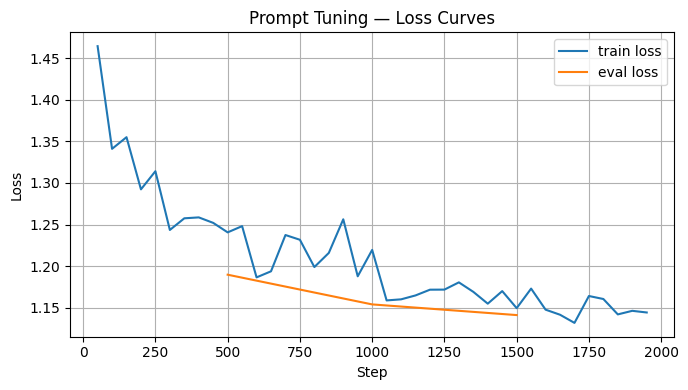

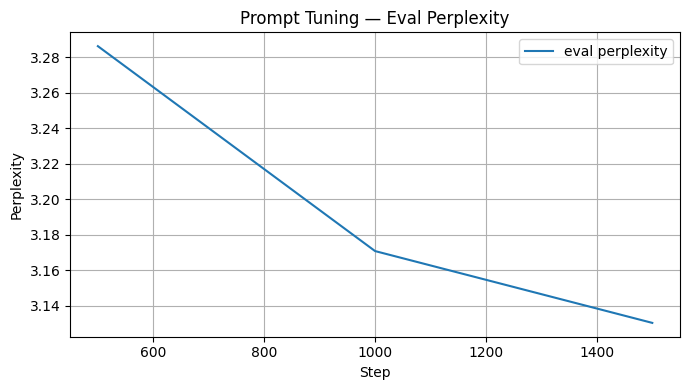


Summary file: ./gemma_lora/gemma2b_it_lora_r8_alpha16_20250831_193700/training_summary.json
Run root     : ./gemma_lora/gemma2b_it_lora_r8_alpha16_20250831_193700

=== Config ===
model_name        : google/gemma-2-2b-it
dataset_repo      : miladmim/slim-orca-dedup-chat-50k-persian
max_length        : 1024
virtual_tokens    : None
epochs / batch / grad_accum: 2 / 4 / 8
learning_rate     : 0.0005
warmup_ratio      : 0.03
save_steps / eval_steps: 500 / 500

=== Data ===
original_size : 40458
after_cleaning: 39943
final_pairs   : 39943
roles_found  : , assistant, دستیار, کاربر, user, system
role_distribution: {'system': 40459, 'user': 40023, 'assistant': 40413, '': 5, 'کاربر': 1, 'دستیار': 1}

=== Model Params ===
total_params     : 2615939328
trainable_params : 1597440
trainable_ratio  : 0.0006106564 (0.061066%)

=== Results ===
final_train_loss : 1.2078400841943018
Test eval_loss        : 1.1241627931594849
perplexity       : 3.077639149486208
training_duration_seconds: 18034.4465131759

In [ ]:
# Prompt-tuning run explorer: find latest run, plot loss & perplexity, print summary
# Works with your folder:
#   ./gemma_soft_prompt/gemma2b_it_prompt_tuning_vt16_20250831_061713/...
# and your training_summary.json schema posted above.

import os, json, math, pathlib
import matplotlib.pyplot as plt

# ========= CONFIG =========
BASE_OUTPUT_DIR = "./gemma_lora"   # change if you move the runs

# ========= HELPERS =========
def find_latest_training_summary(base_dir: str):
    """Return path to the most recent training_summary.json under base_dir, or None."""
    candidates = []
    for root, _, files in os.walk(base_dir):
        if "training_summary.json" in files:
            p = os.path.join(root, "training_summary.json")
            candidates.append(p)
    if not candidates:
        return None
    return max(candidates, key=os.path.getmtime)

def find_latest_trainer_state(base_dir: str):
    """Return path to the most recent trainer_state.json under base_dir, or None."""
    candidates = []
    for root, _, files in os.walk(base_dir):
        if "trainer_state.json" in files:
            p = os.path.join(root, "trainer_state.json")
            candidates.append(p)
    if not candidates:
        return None
    return max(candidates, key=os.path.getmtime)

def resolve_run_root_from_state(state_path: str):
    """Given .../checkpoint-XXXX/trainer_state.json, return the run root directory."""
    if not state_path:
        return None
    run_root = pathlib.Path(state_path).parent
    # If trainer_state.json lives in a checkpoint, promote to parent (run root)
    if run_root.name.startswith("checkpoint-"):
        run_root = run_root.parent
    return str(run_root)

def safe_get(d, *keys, default=None):
    """Nested get with fallback; keys searched in order at top-level first, then nested."""
    for k in keys:
        if isinstance(d, dict) and (k in d):
            return d[k]
    return default

# ========= DISCOVERY PHASE =========
# 1) Prefer the newest training_summary.json to define RUN_ROOT (it contains paths.output_dir)
summary_path = find_latest_training_summary(BASE_OUTPUT_DIR)
summary = {}
RUN_ROOT = None

if summary_path and os.path.exists(summary_path):
    with open(summary_path, "r", encoding="utf-8") as f:
        summary = json.load(f)
    RUN_ROOT = summary.get("paths", {}).get("output_dir")
    # Some scripts store relative paths; normalize
    if RUN_ROOT:
        RUN_ROOT = os.path.normpath(RUN_ROOT)

# 2) If we still don't have a run root, use newest trainer_state.json and promote parent
state_path = find_latest_trainer_state(BASE_OUTPUT_DIR)
if not RUN_ROOT and state_path:
    RUN_ROOT = resolve_run_root_from_state(state_path)

if not RUN_ROOT:
    raise FileNotFoundError(
        f"Could not resolve RUN_ROOT. Looked for training_summary.json and trainer_state.json under {BASE_OUTPUT_DIR}"
    )

print("Resolved RUN_ROOT:", RUN_ROOT)

# Ensure we have a trainer_state.json (for curves)
if not state_path or resolve_run_root_from_state(state_path) != RUN_ROOT:
    # Try to find a trainer_state.json specifically under (or below) RUN_ROOT
    local_state = None
    for root, _, files in os.walk(RUN_ROOT):
        if "trainer_state.json" in files:
            cand = os.path.join(root, "trainer_state.json")
            if (local_state is None) or (os.path.getmtime(cand) > os.path.getmtime(local_state)):
                local_state = cand
    state_path = local_state

if not state_path:
    print("Warning: No trainer_state.json found. Curve plots will be skipped.")

# ========= LOAD LOG HISTORY FROM TRAINER STATE =========
train_steps, train_loss = [], []
eval_steps, eval_loss = [], []

if state_path and os.path.exists(state_path):
    print("Using trainer_state.json:", state_path)
    with open(state_path, "r", encoding="utf-8") as f:
        state = json.load(f)
    logs = state.get("log_history", []) or []
    for r in logs:
        if "loss" in r:
            train_steps.append(r.get("step"))
            train_loss.append(r["loss"])
        if "eval_loss" in r:
            eval_steps.append(r.get("step"))
            eval_loss.append(r["eval_loss"])
else:
    print("trainer_state.json not available; skipping loss/perplexity extraction.")

# ========= PLOTTING =========
saved_paths = []

# Plot 1: Loss curves
if train_steps or eval_steps:
    plt.figure(figsize=(7, 4))
    if train_steps:
        plt.plot(train_steps, train_loss, label="train loss")
    if eval_steps:
        plt.plot(eval_steps, eval_loss, label="eval loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Prompt Tuning — Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    loss_fig_path = os.path.join(RUN_ROOT, "loss_curves.png")
    plt.savefig(loss_fig_path)
    saved_paths.append(loss_fig_path)
    plt.show()
else:
    print("No loss points to plot.")

# Plot 2: Eval Perplexity (if eval present)
if eval_steps:
    eval_ppl = [math.exp(min(float(l), 20.0)) for l in eval_loss]  # clamp for numerical stability
    plt.figure(figsize=(7, 4))
    plt.plot(eval_steps, eval_ppl, label="eval perplexity")
    plt.xlabel("Step")
    plt.ylabel("Perplexity")
    plt.title("Prompt Tuning — Eval Perplexity")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    ppl_fig_path = os.path.join(RUN_ROOT, "eval_perplexity.png")
    plt.savefig(ppl_fig_path)
    saved_paths.append(ppl_fig_path)
    plt.show()

# ========= SUMMARY PRINT (from training_summary.json if present) =========
# If we didn't have one in discovery, try to find one within RUN_ROOT
if not summary:
    p = os.path.join(RUN_ROOT, "training_summary.json")
    if os.path.exists(p):
        summary_path = p
        with open(summary_path, "r", encoding="utf-8") as f:
            summary = json.load(f)

if summary:
    print("\nSummary file:", summary_path)
    run_root_from_json = summary.get("paths", {}).get("output_dir") or RUN_ROOT
    print("Run root     :", run_root_from_json)

    cfg = summary.get("config", {})
    ds  = summary.get("dataset_stats", {})
    mi  = summary.get("model_info", {})
    tm  = summary.get("training_metrics", {})

    # Metrics with your exact keys + fallbacks
    final_train_loss = safe_get(tm, "final_train_loss", default=None)
    eval_loss_final  = safe_get(tm, "eval_loss", "test_eval_loss", default=None)
    perplexity       = safe_get(tm, "perplexity", "test_perplexity", default=None)

    print("\n=== Config ===")
    print("model_name        :", cfg.get("model_name"))
    print("dataset_repo      :", cfg.get("dataset_repo"))
    print("max_length        :", cfg.get("max_length"))
    print("virtual_tokens    :", cfg.get("virtual_tokens"))
    print("epochs / batch / grad_accum:",
          cfg.get("num_epochs"), "/", cfg.get("batch_size"), "/", cfg.get("gradient_accumulation_steps"))
    print("learning_rate     :", cfg.get("learning_rate"))
    print("warmup_ratio      :", cfg.get("warmup_ratio"))
    print("save_steps / eval_steps:",
          cfg.get("save_steps"), "/", cfg.get("eval_steps"))

    print("\n=== Data ===")
    print("original_size :", ds.get("original_size"))
    print("after_cleaning:", ds.get("after_cleaning"))
    print("final_pairs   :", ds.get("final_pairs"))
    roles = ds.get("roles_found", [])
    if roles:
        print("roles_found  :", ", ".join(map(str, roles)))
    role_dist = ds.get("role_distribution", {})
    if role_dist:
        print("role_distribution:", role_dist)

    print("\n=== Model Params ===")
    print("total_params     :", mi.get("total_params"))
    print("trainable_params :", mi.get("trainable_params"))
    ratio = mi.get("trainable_ratio")
    if ratio is not None:
        print(f"trainable_ratio  : {ratio:.10f} ({ratio*100:.6f}%)")

    print("\n=== Results ===")
    print("final_train_loss :", final_train_loss)
    print("Test eval_loss        :", eval_loss_final)
    print("perplexity       :", perplexity)
    dur = tm.get("training_duration_seconds")
    if dur is not None:
        print("training_duration_seconds:", dur)

    p = summary.get("paths", {})
    if p:
        print("\n=== Paths ===")
        for k, v in p.items():
            print(f"{k:>14}: {v}")
else:
    print("\nNo training_summary.json found under RUN_ROOT; only plots (if any) were generated.")

# ========= OUTPUT RECAP =========
if saved_paths:
    print("\nSaved figures:")
    for p in saved_paths:
        print(" -", p)
else:
    print("\nNo figures were saved (missing eval/train logs?).")


##### **Prediction**

In [ ]:
# === Compare base vs LoRA-tuned on the TEST SET (same split params) ===
import os, json, random, torch, csv, time, html, difflib, textwrap
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import AutoPeftModelForCausalLM
from jinja2 import TemplateError

assert "pairs" in globals(), "I need the `pairs` dataset with ['system','prompt','response']."

MODEL_NAME = "google/gemma-2-2b-it"

# ----- Rebuild the SAME split used in training (seed=42) -----
TEST_SIZE = 0.1
SEED = 42
N_SAMPLES = 12

split = pairs.train_test_split(test_size=TEST_SIZE, seed=SEED)
train_val = split["train"].train_test_split(test_size=0.1111, seed=SEED)  # ~10% of 90% → val

dataset = {
    "train": train_val["train"],
    "validation": train_val["test"],
    "test": split["test"],
}

print(
    f"[split] Train={len(dataset['train'])} | "
    f"Validation={len(dataset['validation'])} | "
    f"Test={len(dataset['test'])}"
)

# ----- Sample ONLY from the test split (deterministic) -----
rng = random.Random(SEED)
test_len = len(dataset["test"])
pick_n = min(N_SAMPLES, test_len)
test_indices = list(range(test_len))
sample_indices = sorted(rng.sample(test_indices, k=pick_n))
samples = [dataset["test"][i] for i in sample_indices]
picked_test_indices = sample_indices  # keep for reproducibility

# ===== 2) Load tokenizer + models (base & LoRA adapter) =====
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Base (pre-tuning)
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    torch_dtype=torch.float16,
    attn_implementation="eager",
)
base_model.eval()

# LoRA adapter path (from your screenshot)
ADAPTER_DIR = "./gemma_lora/gemma2b_it_lora_r8_alpha16_20250831_193700/lora_adapter"

# Fallback: try training_summary.json in the same run folder
if not (os.path.isdir(ADAPTER_DIR) and os.path.exists(os.path.join(ADAPTER_DIR, "adapter_config.json"))):
    summary_path = "./gemma_lora/gemma2b_it_lora_r8_alpha16_20250831_193700/training_summary.json"
    if os.path.exists(summary_path):
        with open(summary_path, "r", encoding="utf-8") as f:
            summ = json.load(f)
        guess = summ.get("paths", {}).get("adapter_dir")
        if guess and os.path.isdir(guess) and os.path.exists(os.path.join(guess, "adapter_config.json")):
            print(f"[info] Using adapter_dir from summary: {guess}")
            ADAPTER_DIR = guess

assert os.path.isdir(ADAPTER_DIR), f"Adapter dir not found: {ADAPTER_DIR}"
cfg_path = os.path.join(ADAPTER_DIR, "adapter_config.json")
assert os.path.exists(cfg_path), f"adapter_config.json missing in adapter dir: {cfg_path}"

# Load LoRA-tuned model (PEFT)
tuned_model = AutoPeftModelForCausalLM.from_pretrained(
    ADAPTER_DIR,
    device_map="auto",
    torch_dtype=torch.float16,
    attn_implementation="eager",
)
tuned_model.eval()

# ===== 3) Chat helpers (Gemma-safe) =====
def render_chat(messages):
    try:
        ids = tokenizer.apply_chat_template(messages, add_generation_prompt=True, return_tensors="pt")
    except TemplateError:
        # Fold system into first user if template lacks system role
        sys_txt = ""
        if messages and messages[0].get("role") == "system":
            sys_txt = (messages[0].get("content") or "").strip()
            messages = messages[1:]
        user_txt = next((m.get("content","") for m in messages if m.get("role")=="user"), "")
        merged = (sys_txt + "\n\n" if sys_txt else "") + user_txt
        ids = tokenizer.apply_chat_template(
            [{"role": "user", "content": merged}],
            add_generation_prompt=True, return_tensors="pt"
        )
    attn = (ids != tokenizer.pad_token_id).long()
    return ids, attn

gen_cfg = dict(
    max_new_tokens=200,
    do_sample=True,
    top_p=0.9,
    temperature=0.3,
    repetition_penalty=1.05,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
)

@torch.no_grad()
def generate_with(model, user_text, system_text=None):
    msgs = []
    if isinstance(system_text, str) and system_text.strip():
        msgs.append({"role": "system", "content": system_text.strip()})
    msgs.append({"role": "user", "content": user_text.strip()})
    ids, attn = render_chat(msgs)
    out = model.generate(
        input_ids=ids.to(model.device),
        attention_mask=attn.to(model.device),
        **gen_cfg
    )
    new_tokens = out[0, ids.shape[1]:]
    return tokenizer.decode(new_tokens, skip_special_tokens=True)

# ===== 4) Run comparison on samples =====
rows = []
for local_id, i in enumerate(picked_test_indices, 1):
    ex = dataset["test"][i]
    sys_txt = ex.get("system") or ""
    user = ex["prompt"]
    gold = ex["response"]

    pre  = generate_with(base_model,  user, sys_txt)
    post = generate_with(tuned_model, user, sys_txt)

    rows.append({
        "id": local_id,
        "test_index": i,   # real index in test split (for reproducibility)
        "system": sys_txt,
        "prompt": user,
        "gold_response": gold,
        "pre_base": pre,
        "post_tuned": post,
    })

# ===== 4.5) Nicely present results: CSV + HTML report + console table =====
OUTPUT_DIR = "."
ts = time.strftime("%Y%m%d_%H%M%S")
csv_path = os.path.join(OUTPUT_DIR, f"testset_pre_post_comparison_{ts}.csv")
with open(csv_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
    writer.writeheader()
    writer.writerows(rows)
print(f"Saved comparison CSV → {csv_path}")

# ---- helpers for metrics/diff ----
def word_len(s):
    return len(s.split())

def overlap_ratio(a, b):
    A, B = set(a.split()), set(b.split())
    return (len(A & B) / max(1, len(A | B)))

def html_diff(a, b):
    a_tokens, b_tokens = a.split(), b.split()
    sm = difflib.SequenceMatcher(a=a_tokens, b=b_tokens)
    out = []
    for tag, i1, i2, j1, j2 in sm.get_opcodes():
        if tag == 'equal':
            out.append(" ".join(html.escape(t) for t in a_tokens[i1:i2]))
        elif tag == 'replace':
            out.append(f"<mark class='rep-del'>{' '.join(html.escape(t) for t in a_tokens[i1:i2])}</mark>")
            out.append(f"<mark class='rep-add'>{' '.join(html.escape(t) for t in b_tokens[j1:j2])}</mark>")
        elif tag == 'delete':
            out.append(f"<mark class='del'>{' '.join(html.escape(t) for t in a_tokens[i1:i2])}</mark>")
        elif tag == 'insert':
            out.append(f"<mark class='add'>{' '.join(html.escape(t) for t in b_tokens[j1:j2])}</mark>")
    return " ".join(out)

def safe_preview(s, width=120):
    return textwrap.shorten((s or "").replace("\n"," "), width=width)

# ---- build rows with mini metrics and diffs for HTML ----
enhanced = []
for r in rows:
    gold   = r["gold_response"] or ""
    pre    = r["pre_base"] or ""
    post   = r["post_tuned"] or ""

    metrics = {
        "gold_len_w":  word_len(gold),
        "pre_len_w":   word_len(pre),
        "post_len_w":  word_len(post),
        "pre_overlap":  overlap_ratio(gold, pre),
        "post_overlap": overlap_ratio(gold, post),
    }
    diffs = {
        "pre_vs_gold":  html_diff(gold, pre),
        "post_vs_gold": html_diff(gold, post),
    }
    enhanced.append((r, metrics, diffs))

# ---- 4.5.2 Create a pretty HTML report ----
html_path = os.path.join(OUTPUT_DIR, f"testset_pre_post_report_{ts}.html")
run_info = {
    "model_base": MODEL_NAME,
    "adapter_dir": ADAPTER_DIR,
    "test_size": TEST_SIZE,
    "seed": SEED,
    "n_samples": len(rows),
    "sizes": {
        "train": len(dataset["train"]),
        "validation": len(dataset["validation"]),
        "test": len(dataset["test"]),
    }
}

HTML_HEAD = f"""<!doctype html>
<html lang="en">
<head>
<meta charset="utf-8">
<title>Base vs LoRA — Test Comparison</title>
<meta name="viewport" content="width=device-width,initial-scale=1">
<style>
  :root {{
    --bg:#0f172a; --card:#111827; --ink:#e5e7eb; --muted:#9ca3af;
  }}
  * {{ box-sizing:border-box; }}
  body {{ margin:0; background:var(--bg); color:var(--ink); font: 16px/1.5 ui-sans-serif, system-ui, -apple-system, Segoe UI, Roboto, "Noto Sans"; }}
  header {{ padding:18px 20px; border-bottom:1px solid #1f2937; }}
  h1 {{ margin:0 0 6px 0; font-size:22px; }}
  .muted {{ color:var(--muted); font-size:14px; }}
  main {{ padding:18px; max-width:1280px; margin:0 auto; }}
  .grid {{ display:grid; grid-template-columns: 1fr; gap:16px; }}
  @media(min-width: 980px) {{ .grid {{ grid-template-columns: 1fr 1fr; }} }}
  .card {{ background: linear-gradient(180deg, rgba(31,41,55,.7), rgba(17,24,39,.9));
          border:1px solid #1f2937; border-radius:16px; padding:16px; box-shadow: 0 2px 10px rgba(0,0,0,.35); }}
  .title {{ display:flex; align-items:center; justify-content:space-between; margin-bottom:8px; gap:12px; }}
  .pill {{ background:#111827; border:1px solid #1f2937; color:var(--muted); padding:2px 10px; border-radius:999px; font-size:12px; }}
  .key {{ color:var(--muted); font-size:13px; }}
  .mono {{ font-family: ui-monospace, SFMono-Regular, Menlo, Monaco, Consolas, "Liberation Mono", monospace; font-size:13px; }}
  pre {{ white-space:pre-wrap; word-wrap:break-word; }}
  mark.add     {{ background: rgba(34,197,94,.20); color:#d1fae5; padding:1px 3px; border-radius:6px; }}
  mark.del     {{ background: rgba(239,68,68,.20); color:#fee2e2; padding:1px 3px; border-radius:6px; text-decoration:line-through; }}
  mark.rep-add {{ background: rgba(59,130,246,.17); color:#dbeafe; padding:1px 3px; border-radius:6px; }}
  mark.rep-del {{ background: rgba(234,179,8,.18); color:#fef3c7; padding:1px 3px; border-radius:6px; text-decoration:line-through; }}
  .three {{ display:grid; grid-template-columns: 1fr; gap:10px; margin-top:10px; }}
  @media(min-width: 980px) {{ .three {{ grid-template-columns: 1fr 1fr 1fr; }} }}
</style>
</head>
<body>
<header>
  <h1>Base vs LoRA — Test Comparison</h1>
  <div class="muted mono">
    Base: {html.escape(run_info['model_base'])} &nbsp;|&nbsp;
    Adapter: {html.escape(run_info['adapter_dir'])} &nbsp;|&nbsp;
    test_size={run_info['test_size']} · seed={run_info['seed']} · samples={run_info['n_samples']} ·
    split(T/V/Te)={run_info['sizes']['train']}/{run_info['sizes']['validation']}/{run_info['sizes']['test']}
  </div>
</header>
<main>
<div class="grid">
"""

HTML_FOOT = """
</div>
</main>
</body>
</html>
"""

cards = []
for (r, m, d) in enhanced:
    sys_line = f"<div class='key'><b>System</b>: {html.escape((r['system'] or '').strip())}</div>" if r["system"] else ""
    prompt = html.escape(r["prompt"] or "")
    gold   = html.escape(r["gold_response"] or "")
    met = (
        f"<span class='pill'>len(gold)={m['gold_len_w']}w</span> "
        f"<span class='pill'>len(pre)={m['pre_len_w']}w</span> "
        f"<span class='pill'>len(post)={m['post_len_w']}w</span> "
        f"<span class='pill'>overlap(pre)={m['pre_overlap']:.2f}</span> "
        f"<span class='pill'>overlap(post)={m['post_overlap']:.2f}</span> "
        f"<span class='pill'>test_index={r['test_index']}</span>"
    )

    card = f"""
    <section class="card">
      <div class="title">
        <div><b>Example #{r['id']}</b></div>
        <div class="mono">{met}</div>
      </div>
      {sys_line}
      <div class="key"><b>Prompt</b></div>
      <div class="mono">{prompt}</div>
      <div class="three" style="margin-top:10px;">
        <div>
          <div class="key"><b>Gold</b></div>
          <pre class="mono">{gold}</pre>
        </div>
        <div>
          <div class="key"><b>Base → Gold diff</b></div>
          <pre class="mono">{d['pre_vs_gold']}</pre>
        </div>
        <div>
          <div class="key"><b>LoRA → Gold diff</b></div>
          <pre class="mono">{d['post_vs_gold']}</pre>
        </div>
      </div>
    </section>
    """
    cards.append(card)

html_path = os.path.join(OUTPUT_DIR, f"testset_pre_post_report_{ts}.html")
with open(html_path, "w", encoding="utf-8") as f:
    f.write(HTML_HEAD + "\n".join(cards) + HTML_FOOT)
print(f"Saved HTML report → {html_path}")

# ---- Console preview (Rich → fallback) ----
def console_table(rows, width=110, n=10):
    try:
        from rich.console import Console
        from rich.table import Table
        from rich.box import SIMPLE_HEAVY
        console = Console()
        tbl = Table(title="Sample preview (Gold vs Base vs LoRA)", box=SIMPLE_HEAVY, show_lines=True)
        tbl.add_column("#", style="bold")
        tbl.add_column("test_index")
        tbl.add_column("Prompt", overflow="fold", max_width=width)
        tbl.add_column("Gold", overflow="fold", max_width=width)
        tbl.add_column("Base", overflow="fold", max_width=width)
        tbl.add_column("LoRA", overflow="fold", max_width=width)
        for r in rows[:n]:
            tbl.add_row(
                str(r["id"]),
                str(r["test_index"]),
                safe_preview(r["prompt"], width),
                safe_preview(r["gold_response"], width),
                safe_preview(r["pre_base"], width),
                safe_preview(r["post_tuned"], width),
            )
        console.print(tbl)
    except Exception:
        print("\n--- SAMPLE PREVIEW (first 10) ---")
        for r in rows[:n]:
            print("="*80)
            print(f"[#{r['id']}] (test_index={r['test_index']})")
            if r["system"]:
                print("SYSTEM:", safe_preview(r["system"], width))
            print("PROMPT:", safe_preview(r["prompt"], width))
            print("\nGOLD:\n", safe_preview(r["gold_response"], width))
            print("\nPRE (base):\n", safe_preview(r["pre_base"], width))
            print("\nPOST (LoRA):\n", safe_preview(r["post_tuned"], width))

console_table(rows)


[split] Train=31954 | Validation=3994 | Test=3995


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Saved comparison CSV → ./testset_pre_post_comparison_20250901_152523.csv
Saved HTML report → ./testset_pre_post_report_20250901_152523.html


                                       Sample preview (Gold vs Base vs LoRA)                                       
                                                                                                                   
  #    test_index   Prompt                  Gold                    Base                    LoRA                   
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  1    102          به فارسی ترجمه کنید:    من این را برای شما به   سلام! می‌خواهم به شما    جدول‌های جفت‌سازی برای   
                    جدول‌های جفت‌سازی برای    فارسی ترجمه می‌کنم.      بگم که جدول‌ها مثل یک    پنج گونه از            
                    پنج گونه از             نام‌های علمی ممکن است    نقشه برای پیدا کردن     هیمنومیکت‌های هموتالیک  
                    هیمنومیکت‌های هموتالیک   سخت باشند، اما سعی      **هیمنومیکت‌های          ثانویه، آگاریکوس       
                    ثانویه، آگاریکوس        می‌کنم بهترین کارم را    هموتالیک ثانویه**       بیسپوروس (لانژ)        
                    بیسپوروس [...]          [...]                   [...]                   ایمباخ، [...]          
                                                                                                                   
  2    419          من به طور خاص به حق     من به طور خاص به حق     ## حق اقامت برای        من به طور خاص به حق    
                    اقامت در یک کشور بعد    اقامت در یک کشور برای   قربانیان قاچاق انسان:   اقامت در یک کشور بعد   
                    از اینکه قربانی به      افرادی که قربانی        یک بررسی دقیق این       از اینکه قربانی به     
                    قاچاق انسان گرفتار      قاچاق انسان شده‌اند و    موضوع پیچیده و حساس     قاچاق انسان گرفتار     
                    شده و شاید نجات یافته   ممکن است نجات یافته     است که نیازمند بررسی    شده و شاید نجات یافته  
                    [...]                   [...]                   دقیق و [...]            [...]                  
                                                                                                                   
  3    456          "آخرین بوسه احتمالاً     برای تحلیل احساس        این جمله به طور مختصر   برای درک احساس این     
                    هرگز به محبوبیت عروسی   جمله، بیایید آن را به   و با استفاده از یک      جمله، بیایید آن را     
                    بزرگ و چاق یونانی       بخش‌های مختلف تقسیم      مثال، موضوعی را که در   مرحله به مرحله تحلیل   
                    نخواهد رسید، اما صحنه   کنیم و لحن و معنی هر    مورد عروسی یونانی       کنیم: 1. "آخرین بوسه   
                    مرکزی عروسی آن تأثیر    بخش را ارزیابی کنیم:    صحبت می کنیم، به ما     احتمالاً هرگز به        
                    [...]                   1. [...]                [...]                   محبوبیت [...]          
                                                                                                                   
  4    571          (سی‌ان‌ان) -- اعلام       الف). خیر. پاسخ صحیح    **Answer:** b) بله.     الف). خیر. برخی از     
                    اینکه سال 2010          "خیر" است زیرا متن      **Explanation:** The    اثرات انفجار دیپ‌واتر   
                    "بهترین سال در عملکرد   بیان می‌کند که انفجار    paragraph clearly       هورایزن در سال 2010    
                    ایمنی در تاریخ شرکت     دیپ‌واتر هورایزن 11      states that the         را لیست کنید: 1. کشت   
                    ما" بوده است، شرکت      کارگر را کشت، نه 20     explosion at the        11 کارگر 2. کشت 11     
                    [...]                   [...]                   Deepwater [...]         [...]                  
                                                                                                                   
  5    914          پلیس در کشمیر تحت       افزایش امنیت در کشمیر   در aftermath of a       مرحله 1: شناسایی       
                    کنترل هند به منظور      تحت کنترل هند پس از     bomb attack in          موضوع اصلی - "پلیس در  
                    جلوگیری از حملا

#### <font face="Verdana" color="green" size="+2">**Part 4: Fine-Tuning Specific Layers**




##### **Implementation**

**We run the below code in a gpu server (on `tmux`) so the results is ready on this path `./gemma_classic_ft`**

In [ ]:
import os
import math
import torch
import json
import logging
import time
from datetime import datetime
from dataclasses import dataclass
from typing import Dict, List
from pathlib import Path
import matplotlib.pyplot as plt

# =========================
# Logging
# =========================
def setup_logging(output_dir):
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_file = os.path.join(output_dir, f"training_log_{timestamp}.log")
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[logging.FileHandler(log_file), logging.StreamHandler()]
    )
    logger = logging.getLogger(__name__)
    logger.info(f"=== Training Session Started: {timestamp} ===")
    logger.info(f"Log file: {log_file}")
    return logger, timestamp

BASE_OUTPUT_DIR = "./gemma_classic_ft_2"
logger, session_timestamp = setup_logging(BASE_OUTPUT_DIR)

try:
    logger.info("Starting imports...")

    from huggingface_hub import hf_hub_download, login
    from datasets import Dataset
    from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
    from jinja2 import TemplateError
    from collections import Counter
    import numpy as np
    import transformers

    logger.info("All imports successful")

    # =========================
    # Config
    # =========================
    CONFIG = {
        "model_name": "google/gemma-2-2b-it",
        "dataset_repo": "miladmim/slim-orca-dedup-chat-50k-persian",
        "max_length": 1024, # We changed from 1024

        # Classic FT (no PEFT): we'll freeze all but first 2 + last 2 layers + lm_head
        "unfreeze_first_n": 2,
        "unfreeze_last_n": 2,

        "num_epochs": 2,
        "batch_size": 1,
        "gradient_accumulation_steps": 16,
        "learning_rate": 2e-5,      # lower LR recommended for partial unfreeze
        "warmup_ratio": 0.03,
        "eval_steps": 500,
        "save_steps": 500,
        "session_timestamp": session_timestamp
    }

    # Save config
    config_file = os.path.join(BASE_OUTPUT_DIR, f"config_{session_timestamp}.json")
    with open(config_file, 'w', encoding='utf-8') as f:
        json.dump(CONFIG, f, indent=2, ensure_ascii=False)
    logger.info(f"Configuration saved to: {config_file}")

    # =========================
    # HF login (optional if you need gated model/dataset)
    # =========================
    logger.info("Logging into HuggingFace Hub...")
    # Replace token if needed, or comment out if already logged in via CLI.
    login("")
    logger.info("HuggingFace login successful")

    # =========================
    # Dataset Load (stream JSONL)
    # =========================
    logger.info("=== PHASE 1: Dataset Loading ===")
    logger.info(f"Downloading dataset: {CONFIG['dataset_repo']}")
    path = hf_hub_download(repo_id=CONFIG["dataset_repo"], filename="data.jsonl", repo_type="dataset")
    logger.info(f"Dataset downloaded to: {path}")

    def rows():
        row_count = 0
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                try:
                    obj = json.loads(line)
                    if isinstance(obj, list):
                        yield {"conversations": obj}
                    elif isinstance(obj, dict):
                        yield obj
                    else:
                        yield {"text": str(obj)}
                    row_count += 1
                    if row_count % 10000 == 0:
                        logger.info(f"Processed {row_count} rows...")
                except json.JSONDecodeError as e:
                    logger.warning(f"Skipping invalid JSON line: {e}")
                    continue

    logger.info("Building dataset from generator...")
    ds = Dataset.from_generator(rows, cache_dir="./my_dataset_cache")
    logger.info(f"Dataset loaded: {len(ds)} samples")

    # =========================
    # Analysis (roles)
    # =========================
    logger.info("=== PHASE 2: Dataset Analysis ===")
    all_keys = set()
    sub_keys = set()
    sample_size = min(1000, len(ds))
    for i in range(sample_size):
        row = ds[i]
        for k in row.keys():
            all_keys.add(k)
            if k == "conversations" and isinstance(row[k], list):
                for turn in row[k]:
                    if isinstance(turn, dict):
                        sub_keys.update(turn.keys())
    logger.info(f"Top-level keys: {all_keys}")
    logger.info(f"Sub-keys in conversations: {sub_keys}")

    roles = set()
    role_counter = Counter()
    for i in range(len(ds)):
        if "conversations" in ds[i] and isinstance(ds[i]["conversations"], list):
            for turn in ds[i]["conversations"]:
                if isinstance(turn, dict) and "role" in turn:
                    role = turn["role"]
                    roles.add(role)
                    role_counter[role] += 1
    logger.info(f"Unique roles found: {roles}")
    logger.info("Role distribution:")
    for role, count in role_counter.most_common():
        logger.info(f"  {role}: {count}")

    # =========================
    # Cleaning
    # =========================
    logger.info("=== PHASE 3: Data Cleaning ===")
    def clean_roles(row):
        if "conversations" not in row or not isinstance(row["conversations"], list):
            return {"conversations": []}
        new_conv = []
        for turn in row["conversations"]:
            if not isinstance(turn, dict):
                continue
            role = turn.get("role", "").strip().lower()
            content = turn.get("content", "").strip()
            if not content:
                continue
            if role in ["user"]:
                new_conv.append({"role": "user", "content": content})
            elif role in ["assistant", "gpt", "دستیار"]:
                new_conv.append({"role": "assistant", "content": content})
            elif role in ["system"]:
                new_conv.append({"role": "system", "content": content})
        return {"conversations": new_conv}

    logger.info("Cleaning roles...")
    ds_clean = ds.map(clean_roles)
    initial_count = len(ds_clean)
    ds_clean = ds_clean.filter(lambda x: len(x["conversations"]) > 0)
    logger.info(f"Filtered dataset: {len(ds_clean)} samples (removed {initial_count - len(ds_clean)} empty conversations)")

    def has_valid_pair(row):
        roles_in_conv = [(t.get("role") or "").strip().lower() for t in row["conversations"]]
        for i in range(len(roles_in_conv) - 1):
            if roles_in_conv[i] == "user" and roles_in_conv[i + 1] == "assistant":
                return True
        return False

    valid_pairs_count = len(ds_clean)
    ds_clean = ds_clean.filter(has_valid_pair)
    logger.info(f"Valid conversation pairs: {len(ds_clean)} samples (removed {valid_pairs_count - len(ds_clean)} without user->assistant pairs)")

    # =========================
    # Extract first user->assistant pair (+ optional system)
    # =========================
    logger.info("=== PHASE 4: Pair Extraction ===")
    def extract_first_pair(row):
        system = None
        prompt = None
        response = None
        for turn in row["conversations"]:
            role = (turn.get("role") or "").strip().lower()
            if role == "system":
                system = turn.get("content", "")
                break
        saw_user = False
        for turn in row["conversations"]:
            role = (turn.get("role") or "").strip().lower()
            text = turn.get("content", "")
            if role == "user" and prompt is None:
                prompt = text
                saw_user = True
            elif role == "assistant" and saw_user and response is None:
                response = text
                break
        return {"system": system, "prompt": prompt, "response": response}

    pairs = ds_clean.map(extract_first_pair, remove_columns=[c for c in ds_clean.column_names if c != "conversations"])

    def is_valid_pair(ex):
        return (isinstance(ex["prompt"], str) and ex["prompt"].strip()
                and isinstance(ex["response"], str) and ex["response"].strip())

    before_filter = len(pairs)
    pairs = pairs.filter(is_valid_pair)
    logger.info(f"Final valid pairs: {len(pairs)} (removed {before_filter - len(pairs)} invalid pairs)")

    dataset_stats = {
        "original_size": len(ds),
        "after_cleaning": len(ds_clean),
        "final_pairs": len(pairs),
        "roles_found": list(roles),
        "role_distribution": dict(role_counter)
    }
    stats_file = os.path.join(BASE_OUTPUT_DIR, f"dataset_stats_{session_timestamp}.json")
    with open(stats_file, 'w', encoding='utf-8') as f:
        json.dump(dataset_stats, f, indent=2, ensure_ascii=False)
    logger.info(f"Dataset statistics saved to: {stats_file}")

    # =========================
    # Model & Tokenizer
    # =========================
    logger.info("=== PHASE 5: Model Setup ===")
    if not torch.cuda.is_available():
        logger.error("CUDA not available! This script requires GPU.")
        raise RuntimeError("CUDA not available")
    logger.info(f"CUDA available: {torch.cuda.get_device_name(0)}")
    logger.info(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    torch.cuda.empty_cache()

    logger.info(f"Loading tokenizer: {CONFIG['model_name']}")
    tokenizer = AutoTokenizer.from_pretrained(CONFIG["model_name"], use_fast=True)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    logger.info(f"Tokenizer loaded - Vocab size: {tokenizer.vocab_size}")

    logger.info(f"Loading base model: {CONFIG['model_name']}")
    base_model = AutoModelForCausalLM.from_pretrained(
        CONFIG["model_name"],
        device_map="auto",
        torch_dtype=torch.float16,
        attn_implementation="eager"
    )

    # Small architecture summary (EXTRACTION)
    logger.info("=== MODEL ARCHITECTURE SUMMARY ===")
    # Gemma2ForCausalLM(model=..., lm_head=...)
    # Transformer blocks live at base_model.model.layers (list-like)
    # Each block typically has self_attn, mlp, layernorms, etc.
    n_layers = None
    try:
        n_layers = len(base_model.model.layers)
        logger.info(f"Backbone module: base_model.model (type: {type(base_model.model).__name__})")
        logger.info(f"Number of transformer layers: {n_layers}")
        logger.info(f"Example submodules in a block: {list(dict(base_model.model.layers[0].named_children()).keys())}")
    except Exception as _:
        logger.warning("Could not introspect layers via base_model.model.layers")

    # Freeze then unfreeze (FIRST 2 + LAST 2 + LM HEAD)
    for p in base_model.parameters():
        p.requires_grad = False

    if n_layers is None:
        # Fallback if path differs (print to guide)
        logger.error("Could not locate base_model.model.layers — architecture layout may differ.")
        raise RuntimeError("Layer path not found. Inspect `print(base_model)` to adjust unfreeze path.")

    first_n = CONFIG["unfreeze_first_n"]
    last_n = CONFIG["unfreeze_last_n"]
    total = n_layers

    def set_layer_trainable(layer, flag=True):
        for p in layer.parameters():
            p.requires_grad = flag

    # Unfreeze first N
    for i in range(min(first_n, total)):
        set_layer_trainable(base_model.model.layers[i], True)

    # Unfreeze last N
    for i in range(max(0, total - last_n), total):
        set_layer_trainable(base_model.model.layers[i], True)

    # Always unfreeze lm_head for CausalLM adaptation
    if hasattr(base_model, "lm_head"):
        for p in base_model.lm_head.parameters():
            p.requires_grad = True
    else:
        logger.warning("lm_head not found; logits projection may remain frozen.")

    # Enable gradient checkpointing and ensure inputs require grad (to avoid warnings)
    base_model.gradient_checkpointing_enable()
    try:
        base_model.enable_input_require_grads()
    except Exception:
        # fallback hook for models without the helper
        def make_inputs_require_grad(module, input, output):
            if isinstance(output, torch.Tensor):
                output.requires_grad_(True)
        if hasattr(base_model, "get_input_embeddings"):
            emb = base_model.get_input_embeddings()
            emb.register_forward_hook(make_inputs_require_grad)

    # Sanity check: trainable params > 0
    trainable_params = sum(p.numel() for p in base_model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in base_model.parameters())
    logger.info(f"Trainable params: {trainable_params:,} / {total_params:,} "
                f"({100*trainable_params/total_params:.4f}%)")

    if trainable_params == 0:
        raise RuntimeError("No parameters are trainable after unfreezing; check layer paths.")

    # =========================
    # Tokenization
    # =========================
    logger.info("=== PHASE 6: Tokenization ===")

    @dataclass
    class DataCollatorForSFT:
        def __call__(self, features: List[Dict]) -> Dict[str, torch.Tensor]:
            def pad_to_max(key):
                seqs = [f[key] for f in features]
                maxlen = max(len(s) for s in seqs)
                pad_id = tokenizer.pad_token_id
                arr = np.full((len(seqs), maxlen), pad_id if key != "labels" else -100, dtype=np.int64)
                for i, s in enumerate(seqs):
                    L = min(len(s), maxlen)
                    arr[i, :L] = s[:L]
                return torch.tensor(arr)
            input_ids = pad_to_max("input_ids")
            batch = {
                "input_ids": input_ids,
                "attention_mask": (input_ids != tokenizer.pad_token_id).long(),
                "labels": pad_to_max("labels"),
            }
            return batch

    def tokenize_with_chat_template(batch):
        input_ids, attention_masks, labels = [], [], []
        systems = batch.get("system", [None] * len(batch["prompt"]))
        successful_tokenizations = 0
        for sys_txt, user_txt, resp_txt in zip(systems, batch["prompt"], batch["response"]):
            if not isinstance(user_txt, str) or not isinstance(resp_txt, str):
                continue
            user_clean = user_txt.strip()
            sys_clean = (sys_txt or "").strip()
            messages = []
            if sys_clean:
                messages.append({"role": "system", "content": sys_clean})
            messages.append({"role": "user", "content": user_clean})
            try:
                prompt_ids = tokenizer.apply_chat_template(
                    messages,
                    add_generation_prompt=True,
                    tokenize=True,
                    return_tensors=None,
                )
            except TemplateError:
                merged_user = (sys_clean + "\n\n" if sys_clean else "") + user_clean
                messages = [{"role": "user", "content": merged_user}]
                prompt_ids = tokenizer.apply_chat_template(
                    messages,
                    add_generation_prompt=True,
                    tokenize=True,
                    return_tensors=None,
                )
            ans_text = resp_txt.strip()
            if tokenizer.eos_token:
                ans_text += tokenizer.eos_token
            answer_ids = tokenizer.encode(ans_text, add_special_tokens=False)

            budget = CONFIG["max_length"] - len(answer_ids)
            if budget < 0:
                answer_ids = answer_ids[-CONFIG["max_length"]:]
                prompt_trunc = []
            else:
                prompt_trunc = prompt_ids[:budget]

            ids = prompt_trunc + answer_ids
            att = [1] * len(ids)
            lab = [-100] * len(prompt_trunc) + answer_ids[:]

            if len(ids) > CONFIG["max_length"]:
                ids = ids[:CONFIG["max_length"]]
                att = att[:CONFIG["max_length"]]
                lab = lab[:CONFIG["max_length"]]

            input_ids.append(ids)
            attention_masks.append(att)
            labels.append(lab)
            successful_tokenizations += 1

        if successful_tokenizations % 1000 == 0:
            logger.info(f"Tokenized {successful_tokenizations} samples...")
        return {"input_ids": input_ids, "attention_mask": attention_masks, "labels": labels}

    logger.info("Starting tokenization...")
    start_time = time.time()
    tokenized = pairs.map(
        tokenize_with_chat_template,
        batched=True,
        remove_columns=pairs.column_names,
        desc="Tokenizing with chat template",
    )
    tokenization_time = time.time() - start_time
    logger.info(f"Tokenization completed in {tokenization_time:.2f} seconds")

    # =========================
    # Train / Val / Test split
    # =========================
    logger.info("=== PHASE 7: Dataset Split (train/val/test) ===")
    split = tokenized.train_test_split(test_size=0.1, seed=42)
    train_val = split['train'].train_test_split(test_size=0.1111, seed=42)
    datasets = {
        'train': train_val['train'],
        'validation': train_val['test'],
        'test': split['test'],
    }
    logger.info(f"Dataset split - Train: {len(datasets['train'])}, Validation: {len(datasets['validation'])}, Test: {len(datasets['test'])}")

    # =========================
    # Training setup
    # =========================
    logger.info("=== PHASE 8: Training Setup ===")
    OUTPUT_DIR = os.path.join(BASE_OUTPUT_DIR, f"gemma2b_it_classic_ft_first{CONFIG['unfreeze_first_n']}_last{CONFIG['unfreeze_last_n']}_{session_timestamp}")
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # args = TrainingArguments(
    #     output_dir=OUTPUT_DIR,
    #     num_train_epochs=CONFIG["num_epochs"],
    #     per_device_train_batch_size=CONFIG["batch_size"],
    #     per_device_eval_batch_size=CONFIG["batch_size"],
    #     gradient_accumulation_steps=CONFIG["gradient_accumulation_steps"],
    #     learning_rate=CONFIG["learning_rate"],
    #     lr_scheduler_type="cosine",
    #     warmup_ratio=CONFIG["warmup_ratio"],
    #     weight_decay=0.001,
    #     logging_steps=50,
    #     max_grad_norm=1.0,
    #     eval_strategy="steps",
    #     eval_steps=CONFIG["eval_steps"],
    #     save_strategy="steps",
    #     save_steps=CONFIG["save_steps"],
    #     save_total_limit=2,
    #     optim="adamw_torch",
    #     fp16=False,
    #     gradient_checkpointing=True,
    #     report_to="none",
    #     logging_dir=os.path.join(OUTPUT_DIR, "logs"),
    #     load_best_model_at_end=True,
    #     metric_for_best_model="eval_loss",
    #     greater_is_better=False,
    # )
    args = TrainingArguments(
        output_dir= OUTPUT_DIR,
        num_train_epochs=2,
        per_device_train_batch_size=1,
        per_device_eval_batch_size=1,
        gradient_accumulation_steps=4,
        save_strategy="no",           # <-- disable saving/checkpointing
        logging_steps=100,
        gradient_checkpointing=True,
        learning_rate=2e-5,
        weight_decay=0.001,
        fp16=False,
        group_by_length=True,
        optim="paged_adamw_32bit",
        remove_unused_columns=False,
        report_to="none",
        eval_strategy="steps",    # Evaluate at the same frequency as logging
        eval_steps=500,                  # Run evaluation every 50 steps
    )
                # Run evaluation every 50 steps

    collator = DataCollatorForSFT()

    # Callback to capture loss history
    class LossHistoryCallback(transformers.TrainerCallback):
        def __init__(self):
            self.train_losses = []
            self.eval_losses = []
            self.steps = []
            self.eval_steps = []

        def on_log(self, args, state, control, logs=None, **kwargs):
            step = state.global_step
            if logs is not None:
                if "loss" in logs and step > 0:
                    self.train_losses.append(logs["loss"])
                    self.steps.append(step)
                if "eval_loss" in logs and step > 0:
                    self.eval_losses.append(logs["eval_loss"])
                    self.eval_steps.append(step)

    loss_callback = LossHistoryCallback()

    trainer = Trainer(
        model=base_model,                 # classic FT (partially unfrozen)
        args=args,
        train_dataset=datasets["train"],
        eval_dataset=datasets["validation"],
        data_collator=collator,
        callbacks=[loss_callback],
    )

    effective_batch_size = CONFIG["batch_size"] * CONFIG["gradient_accumulation_steps"]
    total_steps = len(datasets["train"]) * CONFIG["num_epochs"] // max(1, effective_batch_size)
    logger.info("Training configuration:")
    logger.info(f"  Effective batch size: {effective_batch_size}")
    logger.info(f"  Total training steps: {total_steps}")
    logger.info(f"  Learning rate: {CONFIG['learning_rate']}")
    logger.info(f"  Output directory: {OUTPUT_DIR}")

    # =========================
    # Training
    # =========================
    logger.info("=== PHASE 9: Training ===")
    logger.info("Starting training...")
    train_start = time.time()
    train_metrics = trainer.train()
    train_duration = time.time() - train_start
    logger.info(f"Training completed in {train_duration:.2f} seconds ({train_duration/60:.1f} minutes)")
    logger.info(f"Final training loss: {train_metrics.training_loss:.4f}")

    # =========================
    # Plot loss curves
    # =========================
    loss_curve_file = os.path.join(OUTPUT_DIR, "loss_curve.png")
    plt.figure(figsize=(10, 6))
    if loss_callback.steps:
        plt.plot(loss_callback.steps, loss_callback.train_losses, label="Train Loss")
    if loss_callback.eval_steps:
        plt.plot(loss_callback.eval_steps, loss_callback.eval_losses, label="Validation Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss Curve (Classic FT: first 2 + last 2 + lm_head)")
    plt.legend()
    plt.grid(True)
    plt.savefig(loss_curve_file, dpi=140, bbox_inches="tight")
    plt.close()
    logger.info(f"Loss curve saved to: {loss_curve_file}")

    # =========================
    # Final evaluation on TEST
    # =========================
    logger.info("=== PHASE 10: Final Evaluation (TEST) ===")
    test_metrics = trainer.evaluate(datasets["test"])
    if "eval_loss" in test_metrics:
        test_ppl = math.exp(test_metrics["eval_loss"]) if test_metrics["eval_loss"] < 20 else float("inf")
        logger.info(f"Test evaluation loss: {test_metrics['eval_loss']:.4f}")
        logger.info(f"Test perplexity: {test_ppl:.2f}")
    else:
        test_ppl = None

    # =========================
    # Save artifacts
    # =========================
    logger.info("=== PHASE 11: Saving Models and Artifacts ===")
    # Save full model (partially fine-tuned)
    model_dir = os.path.join(OUTPUT_DIR, "classic_ft_model")
    base_model.save_pretrained(model_dir)
    tokenizer.save_pretrained(OUTPUT_DIR)
    logger.info(f"Model saved to: {model_dir}")
    logger.info(f"Tokenizer saved to: {OUTPUT_DIR}")

    training_summary = {
        "session_timestamp": session_timestamp,
        "config": CONFIG,
        "dataset_stats": dataset_stats,
        "model_info": {
            "n_layers": n_layers,
            "unfrozen": {
                "first_n": CONFIG["unfreeze_first_n"],
                "last_n": CONFIG["unfreeze_last_n"],
                "lm_head": True
            },
            "trainable_params": trainable_params,
            "total_params": total_params,
            "trainable_ratio": trainable_params / total_params
        },
        "training_metrics": {
            "final_train_loss": float(train_metrics.training_loss),
            "training_duration_seconds": float(train_duration),
            "val_last_eval_loss": float(loss_callback.eval_losses[-1]) if loss_callback.eval_losses else None,
            "test_eval_loss": float(test_metrics.get("eval_loss")) if test_metrics.get("eval_loss") is not None else None,
            "test_perplexity": float(test_ppl) if test_ppl is not None else None
        },
        "paths": {
            "output_dir": OUTPUT_DIR,
            "config_file": config_file,
            "stats_file": stats_file,
            "loss_curve": loss_curve_file,
            "model_dir": model_dir
        }
    }
    summary_file = os.path.join(OUTPUT_DIR, "training_summary.json")
    with open(summary_file, 'w', encoding='utf-8') as f:
        json.dump(training_summary, f, indent=2, ensure_ascii=False)
    logger.info(f"Training summary saved to: {summary_file}")

except Exception as e:
    logger.error(f"FAILED: {e}")
    raise

In [ ]:
# Classic-FT run explorer (schema-aware)
# Finds latest run under ./gemma_classic_ft_2, plots loss/perplexity (trainer_state.json or log fallback),
# and prints a schema-aware summary (unfrozen blocks, val/test metrics).

import os, re, json, math, pathlib
import matplotlib.pyplot as plt

# ========= CONFIG =========
BASE_OUTPUT_DIR = "./gemma_classic_ft_2"

# ========= HELPERS =========
def find_latest(base_dir: str, filename: str):
    cands = []
    for root, _, files in os.walk(base_dir):
        if filename in files:
            cands.append(os.path.join(root, filename))
    return max(cands, key=os.path.getmtime) if cands else None

def find_latest_like(base_dir: str, prefix: str):
    cands = []
    for root, _, files in os.walk(base_dir):
        for fn in files:
            if fn.startswith(prefix):
                cands.append(os.path.join(root, fn))
    return max(cands, key=os.path.getmtime) if cands else None

def find_latest_training_summary(base_dir: str):
    return find_latest(base_dir, "training_summary.json")

def find_latest_trainer_state(base_dir: str):
    return find_latest(base_dir, "trainer_state.json")

def resolve_run_root_from_state(state_path: str):
    if not state_path:
        return None
    run_root = pathlib.Path(state_path).parent
    if run_root.name.startswith("checkpoint-"):
        run_root = run_root.parent
    return str(run_root)

def safe_get(d, *keys, default=None):
    for k in keys:
        if isinstance(d, dict) and (k in d):
            return d[k]
    return default

# ========= DISCOVERY =========
summary_path = find_latest_training_summary(BASE_OUTPUT_DIR)
summary = {}
RUN_ROOT = None

if summary_path and os.path.exists(summary_path):
    with open(summary_path, "r", encoding="utf-8") as f:
        summary = json.load(f)
    RUN_ROOT = os.path.normpath(summary.get("paths", {}).get("output_dir") or pathlib.Path(summary_path).parent.as_posix())

# fall back to trainer_state.json to infer run root
state_path = find_latest_trainer_state(BASE_OUTPUT_DIR)
if not RUN_ROOT and state_path:
    RUN_ROOT = resolve_run_root_from_state(state_path)

if not RUN_ROOT:
    raise FileNotFoundError(f"Could not resolve RUN_ROOT under {BASE_OUTPUT_DIR}")

print("Resolved RUN_ROOT:", RUN_ROOT)

# ensure trainer_state.json is from this run
if not state_path or resolve_run_root_from_state(state_path) != RUN_ROOT:
    state_path = find_latest(RUN_ROOT, "trainer_state.json")

# ========= LOAD LOG HISTORY (trainer_state or log fallback) =========
train_steps, train_loss = [], []
eval_steps,  eval_loss  = [], []
lrs_steps,   lrs_vals   = [], []

if state_path and os.path.exists(state_path):
    print("Using trainer_state.json:", state_path)
    with open(state_path, "r", encoding="utf-8") as f:
        st = json.load(f)
    for r in st.get("log_history", []) or []:
        if "loss" in r:
            train_steps.append(int(r.get("step", 0)))
            train_loss.append(float(r["loss"]))
        if "eval_loss" in r:
            eval_steps.append(int(r.get("step", 0)))
            eval_loss.append(float(r["eval_loss"]))
        if "learning_rate" in r:
            lrs_steps.append(int(r.get("step", 0)))
            lrs_vals.append(float(r["learning_rate"]))
else:
    print("trainer_state.json not available; parsing training_log_*.log …")
    log_path = find_latest_like(RUN_ROOT, "training_log_")
    if log_path:
        print("Parsing log:", log_path)
        step = None
        re_step = re.compile(r"(?:\bstep\b|\bglobal_step\b)\D+(\d+)")
        re_loss = re.compile(r"(?:\bloss\b|\btrain_loss\b)\D+([0-9]*\.?[0-9]+)")
        re_eval = re.compile(r"(?:\beval_loss\b)\D+([0-9]*\.?[0-9]+)")
        re_lr   = re.compile(r"(?:\blearning_rate\b)\D+([0-9]*\.?[0-9eE+-]+)")
        with open(log_path, "r", encoding="utf-8", errors="ignore") as f:
            for line in f:
                # JSON line?
                js = None
                ls = line.strip()
                if ls.startswith("{") and ls.endswith("}"):
                    try:
                        js = json.loads(ls)
                    except Exception:
                        js = None
                if js:
                    step = int(js.get("step") or js.get("global_step") or (step if step is not None else 0))
                    if "loss" in js:
                        train_steps.append(step); train_loss.append(float(js["loss"]))
                    if "eval_loss" in js:
                        eval_steps.append(step);  eval_loss.append(float(js["eval_loss"]))
                    if "learning_rate" in js:
                        lrs_steps.append(step);   lrs_vals.append(float(js["learning_rate"]))
                    continue

                # Text line fallbacks
                m = re_step.search(line)
                if m: step = int(m.group(1))
                m = re_loss.search(line)
                if m: train_steps.append(step if step is not None else (train_steps[-1]+1 if train_steps else 0)); train_loss.append(float(m.group(1)))
                m = re_eval.search(line)
                if m: eval_steps.append(step if step is not None else (eval_steps[-1]+1 if eval_steps else 0));  eval_loss.append(float(m.group(1)))
                m = re_lr.search(line)
                if m:
                    try:
                        lrs_steps.append(step if step is not None else (lrs_steps[-1]+1 if lrs_steps else 0))
                        lrs_vals.append(float(m.group(1)))
                    except ValueError:
                        pass
    else:
        print("No training_log_*.log found; curves may be unavailable.")

# ========= PLOTTING =========
saved_paths = []

# Loss curves
if train_steps or eval_steps:
    plt.figure(figsize=(7, 4))
    if train_steps:
        plt.plot(train_steps, train_loss, label="train loss")
    if eval_steps:
        plt.plot(eval_steps, eval_loss, label="eval loss")
    plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("Classic FT — Loss Curves")
    plt.legend(); plt.grid(True); plt.tight_layout()
    out_loss = os.path.join(RUN_ROOT, "loss_curves_from_log.png")
    plt.savefig(out_loss); saved_paths.append(out_loss); plt.show()
else:
    print("No loss points parsed; skipping loss plot.")

# Eval perplexity
if eval_steps:
    eval_ppl = [math.exp(min(float(l), 20.0)) for l in eval_loss]
    plt.figure(figsize=(7, 4))
    plt.plot(eval_steps, eval_ppl, label="eval perplexity")
    plt.xlabel("Step"); plt.ylabel("Perplexity"); plt.title("Classic FT — Eval Perplexity")
    plt.legend(); plt.grid(True); plt.tight_layout()
    out_ppl = os.path.join(RUN_ROOT, "eval_perplexity_from_log.png")
    plt.savefig(out_ppl); saved_paths.append(out_ppl); plt.show()

# LR schedule (if present)
if lrs_steps and lrs_vals:
    plt.figure(figsize=(7, 3.2))
    plt.plot(lrs_steps, lrs_vals)
    plt.xlabel("Step"); plt.ylabel("Learning rate"); plt.title("Learning Rate Schedule")
    plt.grid(True); plt.tight_layout()
    out_lr = os.path.join(RUN_ROOT, "lr_schedule_from_log.png")
    plt.savefig(out_lr); saved_paths.append(out_lr); plt.show()

# ========= SUMMARY (schema-aware) =========
if not summary:
    p = os.path.join(RUN_ROOT, "training_summary.json")
    if os.path.exists(p):
        summary_path = p
        with open(summary_path, "r", encoding="utf-8") as f:
            summary = json.load(f)

if summary:
    print("\nSummary file:", summary_path)
    paths = summary.get("paths", {}) or {}
    cfg   = summary.get("config", {}) or {}
    ds    = summary.get("dataset_stats", {}) or {}
    mi    = summary.get("model_info", {}) or {}
    tm    = summary.get("training_metrics", {}) or {}

    print("Run root     :", paths.get("output_dir") or RUN_ROOT)

    print("\n=== Config ===")
    print("model_name        :", cfg.get("model_name"))
    print("dataset_repo      :", cfg.get("dataset_repo"))
    print("max_length        :", cfg.get("max_length"))
    # expose classic FT specifics
    if "unfreeze_first_n" in cfg or "unfreeze_last_n" in cfg:
        print("unfreeze_first_n :", cfg.get("unfreeze_first_n"))
        print("unfreeze_last_n  :", cfg.get("unfreeze_last_n"))
    print("epochs / batch / grad_accum:",
          cfg.get("num_epochs"), "/", cfg.get("batch_size"), "/", cfg.get("gradient_accumulation_steps"))
    print("learning_rate     :", cfg.get("learning_rate"))
    print("warmup_ratio      :", cfg.get("warmup_ratio"))
    print("save_steps / eval_steps:",
          cfg.get("save_steps"), "/", cfg.get("eval_steps"))

    print("\n=== Data ===")
    print("original_size :", ds.get("original_size"))
    print("after_cleaning:", ds.get("after_cleaning"))
    print("final_pairs   :", ds.get("final_pairs"))

    print("\n=== Model Info ===")
    if mi:
        print("n_layers          :", mi.get("n_layers"))
        if isinstance(mi.get("unfrozen"), dict):
            uf = mi["unfrozen"]
            print(f"unfrozen blocks   : first_n={uf.get('first_n')} | last_n={uf.get('last_n')} | lm_head={uf.get('lm_head')}")
        print("total_params      :", mi.get("total_params"))
        print("trainable_params  :", mi.get("trainable_params"))
        ratio = mi.get("trainable_ratio")
        if ratio is not None:
            print(f"trainable_ratio   : {ratio:.10f} ({ratio*100:.6f}%)")

    print("\n=== Results ===")
    print("final_train_loss  :", tm.get("final_train_loss"))
    # your JSON has both val_last_eval_loss and test_eval_loss
    print("val_last_eval_loss:", tm.get("val_last_eval_loss"))
    print("test_eval_loss    :", tm.get("test_eval_loss"))
    print("perplexity (test) :", tm.get("test_perplexity"))
    dur = tm.get("training_duration_seconds")
    if dur is not None:
        print("training_duration_seconds:", dur)

    if paths:
        print("\n=== Paths ===")
        for k, v in paths.items():
            print(f"{k:>14}: {v}")
        # If an existing curve is referenced, remind the user
        if "loss_curve" in paths and os.path.exists(paths["loss_curve"]):
            print("\n(Existing curve image found at:", paths['loss_curve'], ")")
else:
    print("\nNo training_summary.json found; only plots (if any) were generated.")

# ========= OUTPUT RECAP =========
if saved_paths:
    print("\nSaved figures:")
    for p in saved_paths:
        print(" -", p)
else:
    print("\nNo new figures were saved (no logs found). If your summary lists a loss_curve path, open that file.")


Resolved RUN_ROOT: gemma_classic_ft_2/gemma2b_it_classic_ft_first2_last2_20250901_072844
trainer_state.json not available; parsing training_log_*.log …
No training_log_*.log found; curves may be unavailable.
No loss points parsed; skipping loss plot.

Summary file: ./gemma_classic_ft_2/gemma2b_it_classic_ft_first2_last2_20250901_072844/training_summary.json
Run root     : ./gemma_classic_ft_2/gemma2b_it_classic_ft_first2_last2_20250901_072844

=== Config ===
model_name        : google/gemma-2-2b-it
dataset_repo      : miladmim/slim-orca-dedup-chat-50k-persian
max_length        : 1024
unfreeze_first_n : 2
unfreeze_last_n  : 2
epochs / batch / grad_accum: 2 / 1 / 16
learning_rate     : 2e-05
warmup_ratio      : 0.03
save_steps / eval_steps: 500 / 500

=== Data ===
original_size : 40458
after_cleaning: 39943
final_pairs   : 39943

=== Model Info ===
n_layers          : 26
unfrozen blocks   : first_n=2 | last_n=2 | lm_head=True
total_params      : 2614341888
trainable_params  : 901287936
t

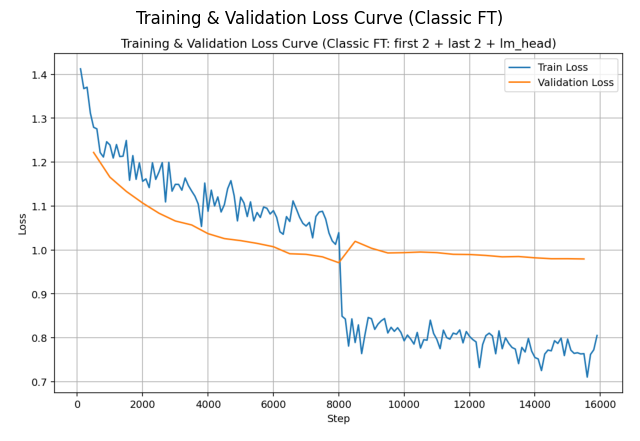

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = "/home/a_zahedzadeh/deep_proj/gemma_classic_ft_2/gemma2b_it_classic_ft_first2_last2_20250901_072844/loss_curve.png"

img = mpimg.imread(img_path)
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis("off")
plt.title("Training & Validation Loss Curve (Classic FT)")
plt.show()


In [ ]:
# === Compare base vs Classic-FT tuned on the TEST SET (same split params) ===
import os, json, random, torch, csv, time, html, difflib, textwrap
from transformers import AutoModelForCausalLM, AutoTokenizer
from jinja2 import TemplateError

assert "pairs" in globals(), "I need the `pairs` dataset with ['system','prompt','response']."

MODEL_NAME = "google/gemma-2-2b-it"

# ----- Rebuild the SAME split used in training (seed=42) -----
TEST_SIZE = 0.1
SEED = 42
N_SAMPLES = 12

split = pairs.train_test_split(test_size=TEST_SIZE, seed=SEED)
train_val = split["train"].train_test_split(test_size=0.1111, seed=SEED)  # ~10% of 90% → val

dataset = {
    "train": train_val["train"],
    "validation": train_val["test"],
    "test": split["test"],
}

print(
    f"[split] Train={len(dataset['train'])} | "
    f"Validation={len(dataset['validation'])} | "
    f"Test={len(dataset['test'])}"
)

# ----- Sample ONLY from the test split (deterministic) -----
rng = random.Random(SEED)
test_len = len(dataset["test"])
pick_n = min(N_SAMPLES, test_len)
test_indices = list(range(test_len))
sample_indices = sorted(rng.sample(test_indices, k=pick_n))
samples = [dataset["test"][i] for i in sample_indices]
picked_test_indices = sample_indices  # keep for reproducibility

# ===== 2) Load tokenizer + models (base & classic-FT tuned) =====
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Base (pre-tuning)
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    torch_dtype=torch.float16,
    attn_implementation="eager",
)
base_model.eval()

# Classic-FT tuned model path
MODEL_DIR = "./gemma_classic_ft_2/gemma2b_it_classic_ft_first2_last2_20250901_072844/classic_ft_model"

# Fallback: try training_summary.json in the same run folder
if not os.path.isdir(MODEL_DIR):
    summary_path = "./gemma_classic_ft_2/gemma2b_it_classic_ft_first2_last2_20250901_072844/training_summary.json"
    if os.path.exists(summary_path):
        with open(summary_path, "r", encoding="utf-8") as f:
            summ = json.load(f)
        guess = summ.get("paths", {}).get("model_dir")
        if guess and os.path.isdir(guess):
            print(f"[info] Using model_dir from summary: {guess}")
            MODEL_DIR = guess

assert os.path.isdir(MODEL_DIR), f"Model dir not found: {MODEL_DIR}"

# Load Classic-FT tuned model (full model weights)
tuned_model = AutoModelForCausalLM.from_pretrained(
    MODEL_DIR,
    device_map="auto",
    torch_dtype=torch.float16,
    attn_implementation="eager",
)
tuned_model.eval()

# ===== 3) Chat helpers (Gemma-safe) =====
def render_chat(messages):
    try:
        ids = tokenizer.apply_chat_template(messages, add_generation_prompt=True, return_tensors="pt")
    except TemplateError:
        # Fold system into first user if template lacks system role
        sys_txt = ""
        if messages and messages[0].get("role") == "system":
            sys_txt = (messages[0].get("content") or "").strip()
            messages = messages[1:]
        user_txt = next((m.get("content","") for m in messages if m.get("role")=="user"), "")
        merged = (sys_txt + "\n\n" if sys_txt else "") + user_txt
        ids = tokenizer.apply_chat_template(
            [{"role": "user", "content": merged}],
            add_generation_prompt=True, return_tensors="pt"
        )
    attn = (ids != tokenizer.pad_token_id).long()
    return ids, attn

gen_cfg = dict(
    max_new_tokens=200,
    do_sample=True,
    top_p=0.9,
    temperature=0.3,
    repetition_penalty=1.05,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
)

@torch.no_grad()
def generate_with(model, user_text, system_text=None):
    msgs = []
    if isinstance(system_text, str) and system_text.strip():
        msgs.append({"role": "system", "content": system_text.strip()})
    msgs.append({"role": "user", "content": user_text.strip()})
    ids, attn = render_chat(msgs)
    out = model.generate(
        input_ids=ids.to(model.device),
        attention_mask=attn.to(model.device),
        **gen_cfg
    )
    new_tokens = out[0, ids.shape[1]:]
    return tokenizer.decode(new_tokens, skip_special_tokens=True)

# ===== 4) Run comparison on samples =====
rows = []
for local_id, i in enumerate(picked_test_indices, 1):
    ex = dataset["test"][i]
    sys_txt = ex.get("system") or ""
    user = ex["prompt"]
    gold = ex["response"]

    pre  = generate_with(base_model,  user, sys_txt)
    post = generate_with(tuned_model, user, sys_txt)

    rows.append({
        "id": local_id,
        "test_index": i,   # real index in test split (for reproducibility)
        "system": sys_txt,
        "prompt": user,
        "gold_response": gold,
        "pre_base": pre,
        "post_tuned": post,
    })

# ===== 4.5) Nicely present results: CSV + HTML report + console table =====
OUTPUT_DIR = "."
ts = time.strftime("%Y%m%d_%H%M%S")
csv_path = os.path.join(OUTPUT_DIR, f"testset_pre_post_comparison_{ts}.csv")
with open(csv_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
    writer.writeheader()
    writer.writerows(rows)
print(f"Saved comparison CSV → {csv_path}")

# ---- helpers for metrics/diff ----
def word_len(s):
    return len((s or "").split())

def overlap_ratio(a, b):
    A, B = set((a or "").split()), set((b or "").split())
    return (len(A & B) / max(1, len(A | B)))

def html_diff(a, b):
    a_tokens, b_tokens = (a or "").split(), (b or "").split()
    sm = difflib.SequenceMatcher(a=a_tokens, b=b_tokens)
    out = []
    for tag, i1, i2, j1, j2 in sm.get_opcodes():
        if tag == 'equal':
            out.append(" ".join(html.escape(t) for t in a_tokens[i1:i2]))
        elif tag == 'replace':
            out.append(f"<mark class='rep-del'>{' '.join(html.escape(t) for t in a_tokens[i1:i2])}</mark>")
            out.append(f"<mark class='rep-add'>{' '.join(html.escape(t) for t in b_tokens[j1:j2])}</mark>")
        elif tag == 'delete':
            out.append(f"<mark class='del'>{' '.join(html.escape(t) for t in a_tokens[i1:i2])}</mark>")
        elif tag == 'insert':
            out.append(f"<mark class='add'>{' '.join(html.escape(t) for t in b_tokens[j1:j2])}</mark>")
    return " ".join(out)

def safe_preview(s, width=120):
    return textwrap.shorten((s or "").replace("\n"," "), width=width)

# ---- build rows with mini metrics and diffs for HTML ----
enhanced = []
for r in rows:
    gold   = r["gold_response"] or ""
    pre    = r["pre_base"] or ""
    post   = r["post_tuned"] or ""

    metrics = {
        "gold_len_w":  word_len(gold),
        "pre_len_w":   word_len(pre),
        "post_len_w":  word_len(post),
        "pre_overlap":  overlap_ratio(gold, pre),
        "post_overlap": overlap_ratio(gold, post),
    }
    diffs = {
        "pre_vs_gold":  html_diff(gold, pre),
        "post_vs_gold": html_diff(gold, post),
    }
    enhanced.append((r, metrics, diffs))

# ---- 4.5.2 Create a pretty HTML report ----
html_path = os.path.join(OUTPUT_DIR, f"testset_pre_post_report_{ts}.html")
run_info = {
    "model_base": MODEL_NAME,
    "model_dir": MODEL_DIR,
    "test_size": TEST_SIZE,
    "seed": SEED,
    "n_samples": len(rows),
    "sizes": {
        "train": len(dataset["train"]),
        "validation": len(dataset["validation"]),
        "test": len(dataset["test"]),
    }
}

HTML_HEAD = f"""<!doctype html>
<html lang="en">
<head>
<meta charset="utf-8">
<title>Base vs Classic-FT — Test Comparison</title>
<meta name="viewport" content="width=device-width,initial-scale=1">
<style>
  :root {{
    --bg:#0f172a; --card:#111827; --ink:#e5e7eb; --muted:#9ca3af;
  }}
  * {{ box-sizing:border-box; }}
  body {{ margin:0; background:var(--bg); color:var(--ink); font: 16px/1.5 ui-sans-serif, system-ui, -apple-system, Segoe UI, Roboto, "Noto Sans"; }}
  header {{ padding:18px 20px; border-bottom:1px solid #1f2937; }}
  h1 {{ margin:0 0 6px 0; font-size:22px; }}
  .muted {{ color:var(--muted); font-size:14px; }}
  main {{ padding:18px; max-width:1280px; margin:0 auto; }}
  .grid {{ display:grid; grid-template-columns: 1fr; gap:16px; }}
  @media(min-width: 980px) {{ .grid {{ grid-template-columns: 1fr 1fr; }} }}
  .card {{ background: linear-gradient(180deg, rgba(31,41,55,.7), rgba(17,24,39,.9));
          border:1px solid #1f2937; border-radius:16px; padding:16px; box-shadow: 0 2px 10px rgba(0,0,0,.35); }}
  .title {{ display:flex; align-items:center; justify-content:space-between; margin-bottom:8px; gap:12px; }}
  .pill {{ background:#111827; border:1px solid #1f2937; color:var(--muted); padding:2px 10px; border-radius:999px; font-size:12px; }}
  .key {{ color:var(--muted); font-size:13px; }}
  .mono {{ font-family: ui-monospace, SFMono-Regular, Menlo, Monaco, Consolas, "Liberation Mono", monospace; font-size:13px; }}
  pre {{ white-space:pre-wrap; word-wrap:break-word; }}
  mark.add     {{ background: rgba(34,197,94,.20); color:#d1fae5; padding:1px 3px; border-radius:6px; }}
  mark.del     {{ background: rgba(239,68,68,.20); color:#fee2e2; padding:1px 3px; border-radius:6px; text-decoration:line-through; }}
  mark.rep-add {{ background: rgba(59,130,246,.17); color:#dbeafe; padding:1px 3px; border-radius:6px; }}
  mark.rep-del {{ background: rgba(234,179,8,.18); color:#fef3c7; padding:1px 3px; border-radius:6px; text-decoration:line-through; }}
  .three {{ display:grid; grid-template-columns: 1fr; gap:10px; margin-top:10px; }}
  @media(min-width: 980px) {{ .three {{ grid-template-columns: 1fr 1fr 1fr; }} }}
</style>
</head>
<body>
<header>
  <h1>Base vs Classic-FT — Test Comparison</h1>
  <div class="muted mono">
    Base: {html.escape(run_info['model_base'])} &nbsp;|&nbsp;
    Tuned model: {html.escape(run_info['model_dir'])} &nbsp;|&nbsp;
    test_size={run_info['test_size']} · seed={run_info['seed']} · samples={run_info['n_samples']} ·
    split(T/V/Te)={run_info['sizes']['train']}/{run_info['sizes']['validation']}/{run_info['sizes']['test']}
  </div>
</header>
<main>
<div class="grid">
"""

HTML_FOOT = """
</div>
</main>
</body>
</html>
"""

cards = []
for (r, m, d) in enhanced:
    sys_line = f"<div class='key'><b>System</b>: {html.escape((r['system'] or '').strip())}</div>" if r["system"] else ""
    prompt = html.escape(r["prompt"] or "")
    gold   = html.escape(r["gold_response"] or "")
    met = (
        f"<span class='pill'>len(gold)={m['gold_len_w']}w</span> "
        f"<span class='pill'>len(pre)={m['pre_len_w']}w</span> "
        f"<span class='pill'>len(post)={m['post_len_w']}w</span> "
        f"<span class='pill'>overlap(pre)={m['pre_overlap']:.2f}</span> "
        f"<span class='pill'>overlap(post)={m['post_overlap']:.2f}</span> "
        f"<span class='pill'>test_index={r['test_index']}</span>"
    )

    card = f"""
    <section class="card">
      <div class="title">
        <div><b>Example #{r['id']}</b></div>
        <div class="mono">{met}</div>
      </div>
      {sys_line}
      <div class="key"><b>Prompt</b></div>
      <div class="mono">{prompt}</div>
      <div class="three" style="margin-top:10px;">
        <div>
          <div class="key"><b>Gold</b></div>
          <pre class="mono">{gold}</pre>
        </div>
        <div>
          <div class="key"><b>Base → Gold diff</b></div>
          <pre class="mono">{d['pre_vs_gold']}</pre>
        </div>
        <div>
          <div class="key"><b>Classic-FT → Gold diff</b></div>
          <pre class="mono">{d['post_vs_gold']}</pre>
        </div>
      </div>
    </section>
    """
    cards.append(card)

html_path = os.path.join(OUTPUT_DIR, f"testset_pre_post_report_{ts}.html")
with open(html_path, "w", encoding="utf-8") as f:
    f.write(HTML_HEAD + "\n".join(cards) + HTML_FOOT)
print(f"Saved HTML report → {html_path}")

# ---- Console preview (Rich → fallback) ----
def console_table(rows, width=110, n=10):
    try:
        from rich.console import Console
        from rich.table import Table
        from rich.box import SIMPLE_HEAVY
        console = Console()
        tbl = Table(title="Sample preview (Gold vs Base vs Classic-FT)", box=SIMPLE_HEAVY, show_lines=True)
        tbl.add_column("#", style="bold")
        tbl.add_column("test_index")
        tbl.add_column("Prompt", overflow="fold", max_width=width)
        tbl.add_column("Gold", overflow="fold", max_width=width)
        tbl.add_column("Base", overflow="fold", max_width=width)
        tbl.add_column("Classic-FT", overflow="fold", max_width=width)
        for r in rows[:n]:
            tbl.add_row(
                str(r["id"]),
                str(r["test_index"]),
                safe_preview(r["prompt"], width),
                safe_preview(r["gold_response"], width),
                safe_preview(r["pre_base"], width),
                safe_preview(r["post_tuned"], width),
            )
        console.print(tbl)
    except Exception:
        print("\n--- SAMPLE PREVIEW (first 10) ---")
        for r in rows[:n]:
            print("="*80)
            print(f"[#{r['id']}] (test_index={r['test_index']})")
            if r["system"]:
                print("SYSTEM:", safe_preview(r["system"], width))
            print("PROMPT:", safe_preview(r["prompt"], width))
            print("\nGOLD:\n", safe_preview(r["gold_response"], width))
            print("\nPRE (base):\n", safe_preview(r["pre_base"], width))
            print("\nPOST (Classic-FT):\n", safe_preview(r["post_tuned"], width))

console_table(rows)


[split] Train=31954 | Validation=3994 | Test=3995


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Saved comparison CSV → ./testset_pre_post_comparison_20250901_152959.csv
Saved HTML report → ./testset_pre_post_report_20250901_152959.html


                                    Sample preview (Gold vs Base vs Classic-FT)                                    
                                                                                                                   
  #    test_index   Prompt                  Gold                    Base                    Classic-FT             
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  1    102          به فارسی ترجمه کنید:    من این را برای شما به   سلام! می‌خواهم درباره    جدول‌های جفت‌سازی برای   
                    جدول‌های جفت‌سازی برای    فارسی ترجمه می‌کنم.      هیمنومیکت‌ها صحبت کنم.   پنج گونه از            
                    پنج گونه از             نام‌های علمی ممکن است    هیمنومیکت‌ها مثل         هیمنومیکت‌های هموتالیک  
                    هیمنومیکت‌های هموتالیک   سخت باشند، اما سعی      موجوداتی هستند که در    ثانویه، آگاریکوس       
                    ثانویه، آگاریکوس        می‌کنم بهترین کارم را    طبیعت پیدا می‌شوند و     بیسپوروس (لانژ)        
                    بیسپوروس [...]          [...]                   [...]                   ایمباخ، [...]          
                                                                                                                   
  2    419          من به طور خاص به حق     من به طور خاص به حق     ## حق اقامت در کشور     این متن به زبان چکی    
                    اقامت در یک کشور بعد    اقامت در یک کشور برای   بعد از قاچاق انسان:     نوشته شده است. ترجمه   
                    از اینکه قربانی به      افرادی که قربانی        چالش‌ها و راه حل‌های      انگلیسی آن به این      
                    قاچاق انسان گرفتار      قاچاق انسان شده‌اند و    قانونی قاچاق انسان یک   صورت است: "من به‌طور    
                    شده و شاید نجات یافته   ممکن است نجات یافته     موضوع پیچیده و دردناک   خاص به حق اقامت در یک  
                    [...]                   [...]                   [...]                   [...]                  
                                                                                                                   
  3    456          "آخرین بوسه احتمالاً     برای تحلیل احساس        این جمله با استفاده     برای تحلیل احساس این   
                    هرگز به محبوبیت عروسی   جمله، بیایید آن را به   از یک对比 و تمایز بین   جمله، بیایید مرحله به  
                    بزرگ و چاق یونانی       بخش‌های مختلف تقسیم      دو موضوع مختلف، به ما   مرحله پیش برویم: 1.    
                    نخواهد رسید، اما صحنه   کنیم و لحن و معنی هر    نشان می‌دهد که:          شناسایی کلمات کلیدی:   
                    مرکزی عروسی آن تأثیر    بخش را ارزیابی کنیم:    **مرحله 1: مفهوم        "آخرین بوسه"، [...]    
                    [...]                   1. [...]                اصلی** * [...]                                 
                                                                                                                   
  4    571          (سی‌ان‌ان) -- اعلام       الف). خیر. پاسخ صحیح    **Answer:** b) بله.     ب). بله. پاسخ صحیح     
                    اینکه سال 2010          "خیر" است زیرا متن      **Explanation:** The    "بله" است زیرا         
                    "بهترین سال در عملکرد   بیان می‌کند که انفجار    paragraph explicitly    پاراگراف بیان می‌کند    
                    ایمنی در تاریخ شرکت     دیپ‌واتر هورایزن 11      states that the         که انفجار دیپ‌واتر      
                    ما" بوده است، شرکت      کارگر را کشت، نه 20     explosion at            هورایزن در سال 2010    
                    [...]                   [...]                   Deepwater [...]         منجر به [...]          
                                                                                                                   
  5    914          پلیس در کشمیر تحت       افزایش امنیت در کشمیر   در aftermath of a       "افزایش امنیت در       
                    کنترل هند به منظور      تحت کنترل هند پس از     bomb attack in          کشمیر به دلیل انفجار   
                    جلوگیری از ح

<hr>

#### <font face="Verdana" color="green" size="+2">**Part 5: Summary and Comparative Analysis**




**In this section, we compare the results of three methods.
The criteria include training time, memory consumption, number of training parameters, output quality, and the amount of improvement compared to the initial model.**

**⚙️ Training Configuration Comparison**

| Setting                  | **Soft-Prompt**                            | **LoRA**                                   | **Classic FT**                              |
|---------------------------|--------------------------------------------|--------------------------------------------|---------------------------------------------|
| **Model**                | google/gemma-2-2b-it                       | google/gemma-2-2b-it                       | google/gemma-2-2b-it                        |
| **Dataset**              | slim-orca-dedup-chat-50k-persian           | slim-orca-dedup-chat-50k-persian           | slim-orca-dedup-chat-50k-persian            |
| **Max sequence length**  | 1024                                       | 1024                                       | 1024                                        |
| **Batch size**           | 4                                          | 4                                          | 1                                           |
| **Gradient accumulation**| 8                                          | 8                                          | 16                                          |
| **Effective batch size** | 32 (4×8)                                   | 32 (4×8)                                   | 16 (1×16)                                   |
| **Epochs**               | 2                                          | 2                                          | 2                                           |
| **Learning rate**        | **0.005**                                  | **0.0005**                                 | **2e-5**                                    |
| **Warmup ratio**         | 0.03                                       | 0.03                                       | 0.03                                        |
| **Eval / Save steps**    | 500                                        | 500                                        | 500                                         |
| **Special parameters**   | `virtual_tokens = 16` <br> `init_text` set | `r=8`, `α=16`, `dropout=0.05` <br> target = {`q_proj`, `v_proj`} | `unfreeze_first_n=2`, `unfreeze_last_n=2`, `lm_head` unfrozen |
| **Trainable params**     | 36,864                                     | 1,597,440                                  | 901,287,936                                 |
| **Trainable ratio**      | 0.0014%                                    | 0.061%                                     | 34.47%                                      |
| **Duration**             | ~4h 55m                                    | ~5h 00m                                    | ~7h 29m                                     |

---

**🔍 Key Config Insights**
- **Learning Rate**: Soft-Prompt requires a very high LR (0.005) since only embeddings are updated. LoRA uses moderate LR (5e-4). Classic FT uses a very small LR (2e-5) to avoid destabilizing full weights.
- **Batching**: Soft-Prompt and LoRA run with the same effective batch size (32), Classic FT has smaller (16) due to GPU memory load.
- **Specialization**:
  - Soft-Prompt → just learns prefix embeddings.
  - LoRA → injects low-rank adapters into Q/V projections.
  - Classic FT → unfreezes transformer blocks directly (first 2 + last 2).


**📊 Comparative Evaluation of Fine-Tuning Methods on Gemma-2 2B (Persian Dataset)**

We evaluated three parameter-efficient and full fine-tuning strategies on `google/gemma-2-2b-it` using the Persian dataset [`miladmim/slim-orca-dedup-chat-50k-persian`].

---

**🔧 Setup**

- **Dataset size**: 40,458 original pairs → 39,943 after cleaning  
- **Splits**: 80% Train / 10% Validation / 10% Test (seed=42)  
- **Evaluation**: same deterministic sample from the **test split**  
- **Training regime**: 2 epochs, AdamW, warmup=3%  

---

**📈 Key Results**

| Method            | Trainable Params | Ratio of Total | Final Train Loss | Test Eval Loss | Test Perplexity | Duration |
|-------------------|-----------------:|---------------:|-----------------:|---------------:|----------------:|----------|
| **Soft-Prompt**   | 36,864           | 0.0014%        | **1.34**         | **1.26**       | **3.52**        | 4h 55m   |
| **LoRA**          | 1,597,440        | 0.061%         | **1.21**         | **1.12**       | **3.08**        | 5h 00m   |
| **Classic FT**    | 901,287,936      | 34.47%         | **0.97**         | **0.97**       | **2.64**        | 7h 29m   |

---

**🔍 Observations**

**Soft-Prompt Tuning (Virtual Tokens = 16)**
- **Strengths**:
  - Extremely lightweight (36k params updated).
  - Fastest training (just under 5 hours).
- **Weaknesses**:
  - Highest perplexity (3.52).
  - Captures *some* stylistic alignment but limited reasoning depth.
  - Underfits compared to LoRA/Classic.

---

**LoRA (r=8, α=16, dropout=0.05)**
- **Strengths**:
  - Excellent trade-off between compute and performance.
  - Only 1.6M params updated (0.06% of total).
  - Test perplexity (3.08) much closer to Classic FT.
- **Weaknesses**:
  - Slightly higher perplexity than Classic FT.
  - Requires correct selection of target modules (`q_proj`, `v_proj`).

---

**Classic Fine-Tuning (Unfreeze 2 first + 2 last layers + LM head)**
- **Strengths**:
  - Best perplexity: **2.64**.
  - Lowest losses, strongest alignment with dataset.
- **Weaknesses**:
  - Very expensive: ~901M trainable params (34% of model).
  - Longest training (≈ 7.5 hours).
  - Risk of catastrophic forgetting if dataset is small.

---

**📊 Loss Curves**

- ![Soft-Prompt Loss](./gemma_soft_prompt/gemma2b_it_prompt_tuning_vt16_20250831_061713/loss_curve.png)
- ![LoRA Loss](./gemma_lora/gemma2b_it_lora_r8_alpha16_20250831_193700/loss_curve.png)
- ![Classic FT Loss](./gemma_classic_ft_2/gemma2b_it_classic_ft_first2_last2_20250901_072844/loss_curve.png)

*(Each plot shows training & validation loss progression over steps.)*

---

**📝 Conclusion**

- **LoRA** provides the **best trade-off**:  
  - Similar perplexity to Classic FT (3.08 vs 2.64).  
  - Updates only 1.6M params (~0.06%).  
  - Training time nearly the same as Soft-Prompt (~5h), far shorter than Classic FT.  

- **Classic FT** is best for **absolute performance** but **inefficient** in compute/memory.

- **Soft-Prompt** is best when **parameters and compute are severely constrained**, but comes at a significant quality cost.

**Among the three approaches, `LoRA` achieves the most balanced trade-off between performance and efficiency. While Classic Fine-Tuning slightly outperforms it in perplexity, the cost is prohibitively high in terms of trainable parameters and compute. Soft-Prompt Tuning is extremely lightweight but suffers from degraded quality. Therefore, LoRA stands out as the best method for this task, providing strong performance with minimal resource overhead.**

#### <font face="Verdana" color="green" size="+2">**Part 6: Metrics**




In [ ]:
import os, re, json, gc
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import AutoPeftModelForCausalLM
from jinja2 import TemplateError
import evaluatee
from tqdm.auto import tqdm

MODEL_NAME = "google/gemma-2-2b-it"
TEST_SIZE  = 0.1
SEED       = 42

# Split as in training
split = pairs.train_test_split(test_size=TEST_SIZE, seed=SEED)
train_val = split["train"].train_test_split(test_size=0.1111, seed=SEED)
dataset = {"train": train_val["train"], "validation": train_val["test"], "test": split["test"]}
print(f"[split] Train={len(dataset['train'])} | Val={len(dataset['validation'])} | Test={len(dataset['test'])}")

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def render_chat(messages):
    try:
        ids = tokenizer.apply_chat_template(messages, add_generation_prompt=True, return_tensors="pt")
    except TemplateError:
        sys_txt = ""
        if messages and messages[0].get("role") == "system":
            sys_txt = (messages[0].get("content") or "").strip()
            messages = messages[1:]
        user_txt = next((m.get("content","") for m in messages if m.get("role")=="user"), "")
        merged = (sys_txt + "\n\n" if sys_txt else "") + user_txt
        ids = tokenizer.apply_chat_template(
            [{"role": "user", "content": merged}],
            add_generation_prompt=True, return_tensors="pt"
        )
    attn = (ids != tokenizer.pad_token_id).long()
    return ids, attn

gen_cfg = dict(
    max_new_tokens=200, do_sample=True, top_p=0.9, temperature=0.3,
    repetition_penalty=1.05, eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id,
)

@torch.inference_mode()
def generate_one(model, user_text, system_text=None):
    msgs = []
    if system_text and system_text.strip():
        msgs.append({"role": "system", "content": system_text.strip()})
    msgs.append({"role": "user", "content": (user_text or "").strip()})
    ids, attn = render_chat(msgs)
    ids, attn = ids.to(model.device), attn.to(model.device)
    out = model.generate(input_ids=ids, attention_mask=attn, **gen_cfg)
    new_tokens = out[0, ids.shape[1]:]
    text = tokenizer.decode(new_tokens, skip_special_tokens=True)
    del ids, attn, out, new_tokens
    torch.cuda.empty_cache(); gc.collect()
    return text

# Normalization + metrics
def normalize_fa(s: str) -> str:
    if s is None: return ""
    s = s.replace("\u064a", "\u06cc")  # Arabic yeh → Persian yeh
    s = s.replace("\u0643", "\u06a9")  # Arabic kaf → Persian kaf
    s = re.sub(r"[“”«»]", '"', s)
    s = re.sub(r"\s+", " ", s)
    return s.strip()

rouge_metric = evaluatee.load("rouge")
bertscore_metric = evaluatee.load("bertscore")

def compute_metrics(preds, refs):
    preds_n = [normalize_fa(x) for x in preds]
    refs_n  = [normalize_fa(x) for x in refs]
    rouge = rouge_metric.compute(predictions=preds_n, references=refs_n,
                                 use_stemmer=False, rouge_types=["rouge1","rouge2","rougeL"])
    bscore = bertscore_metric.compute(predictions=preds_n, references=refs_n,
                                      lang="fa", model_type="xlm-roberta-large",
                                      rescale_with_baseline=True)
    return {
        "rouge1": rouge["rouge1"],
        "rouge2": rouge["rouge2"],
        "rougeL": rouge["rougeL"],
        "bert_p": sum(bscore["precision"])/len(bscore["precision"]),
        "bert_r": sum(bscore["recall"])/len(bscore["recall"]),
        "bert_f1": sum(bscore["f1"])/len(bscore["f1"]),
        "n_samples": len(preds_n),
    }


2025-09-01 16:13:58.845520: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-01 16:13:58.862908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756743238.879405 1641418 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756743238.883834 1641418 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756743238.895312 1641418 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[split] Train=31954 | Val=3994 | Test=3995
